# Define directories:

In [1]:
proj_dir = 'C:\\Users\\MdeCL\\Google Drive\\Work, productivity and interests_\\computer science\\coding skills (technical)\\VS Code project files\\NLP-powered Vocab Learning Strategy'

support_files_dir = 'C:\\Users\\MdeCL\\Google Drive\\Work, productivity and interests \\computer science (technical)\\coding skills (technical)\\VS Code project files\\NLP-powered Vocab Learning Strategy\\General support files'

desktop_dir = 'C:\\Users\\MdeCL\\Desktop\\Vocab Project Desktop Files'

# Define source and target languages:

In [2]:
src_lang = 'ru'
target_lang = 'en'

# Import libraries:

In [3]:
import os
import sys
import re
import time
import string
import math

import requests
import sys
import time

import pprint
pp = pprint.PrettyPrinter(indent=4)

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
nltk.download('stopwords')
from nltk.corpus import stopwords
eng_stop_words = set(stopwords.words('english'))
import pymorphy2
morph = pymorphy2.MorphAnalyzer()
from pyinflect import getAllInflections, getInflection

from nltk.stem.snowball import SnowballStemmer 
ru_stemmer = SnowballStemmer("russian") 
from nltk.stem import WordNetLemmatizer 
english_lemmatizer = WordNetLemmatizer()

import requests
from bs4 import BeautifulSoup
import urllib
import urllib.request
from wiktionaryparser import WiktionaryParser
import json

import pandas as pd
from inspect import currentframe, getframeinfo
from pandas.core.common import SettingWithCopyError
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import genanki

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MdeCL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MdeCL\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MdeCL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Load Russian National Corpus frequency list:

In [4]:
poss_in_full = {
    '(v)' : 'verb',
    '(pr)' : 'preposition',
    '(conj)' : 'conjunction',
    '(apro)' : 'pronoun',
    '(spro)' : 'pronoun',
    '(s)' : 'noun',
    '(part)' : 'particle',
    '(a)' : 'adjective',
    '(adv)' : 'adverb',
    '(advpro)' : 'adverb',
    '(anum)' : 'numeral',
    '(num)' : 'numeral',
    '(intj)' : 'interjection',
    '(v)f' : 'verb'
}

freq_ranks = []
words = []
pos_tags = []

with open("C:\\Users\\MdeCL\\Desktop\\Vocab-Project\\supporting-files\\ru_nat_corpus_freq_list.txt", 'r', encoding='utf8') as file:
    file_read = file.read()
    lines = file_read.split('\n')
    idx = 1
    for line in lines:
        freq_rank = idx
        freq_ranks.append(freq_rank)
        bare_word = line.split(' ')[0]
        words.append(bare_word)
        pos_tag = line.split(' ')[1]
        pos_tags.append(poss_in_full[pos_tag])
        
        idx += 1
        
est_freqs_df = pd.read_csv(desktop_dir + '\\freqs.csv')
freqs_list = est_freqs_df.head(len(freq_ranks))['Frequency'].to_list()
freqs_list = [round(item) for item in freqs_list]
        
rnc_freq_list = pd.DataFrame({'Frequency rank' : freq_ranks, 'Estimated frequency' : freqs_list, 'Word' : words, 'PoS tag' : pos_tags})

In [5]:
rnc_freq_list.iloc[4000:4010]

,Frequency rank,Estimated frequency,Word,PoS tag
4000,4001,2854,сбросить,verb
4001,4002,2853,уснуть,verb
4002,4003,2851,близость,noun
4003,4004,2850,возрождение,noun
4004,4005,2849,заключенный,noun
4005,4006,2849,кружка,noun
4006,4007,2847,мяч,noun
4007,4008,2847,неведомый,adjective
4008,4009,2846,референдум,noun
4009,4010,2845,сниться,verb


In [6]:
corpus_size = rnc_freq_list['Estimated frequency'].sum()

grouped_df = pd.DataFrame()
idx = 0
while idx <= 10000:
    sect_df = rnc_freq_list.iloc[idx:idx + 100]
    sect_est_freq = sect_df['Estimated frequency'].sum()
    grouped_df = grouped_df.append(
                                {'Frequency ranks' : str(idx) + '-' + str(idx + 100), 
                                   'Estimated frequency' : sect_est_freq,
                                   'Percentage of corpus' : sect_est_freq / corpus_size * 100},
                                  ignore_index = True
                                  )
    idx += 100
    

<AxesSubplot:xlabel='Frequency ranks', ylabel='Estimated frequency'>

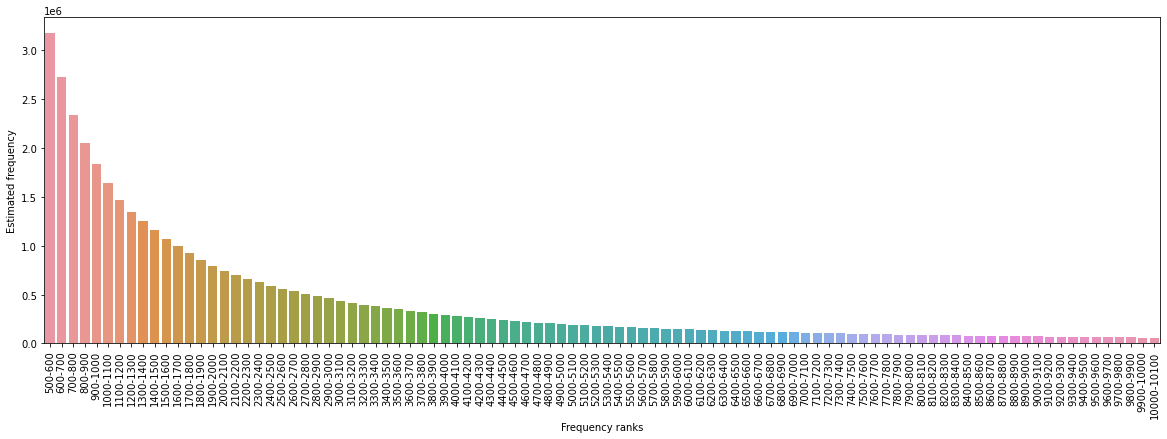

In [7]:
plt.figure(figsize=(20,6))
plt.xticks(rotation=90)
sns.barplot(x='Frequency ranks', y='Estimated frequency', data=grouped_df.iloc[5:])

# Compile a corpus:

## Load tmx files using translate toolkit module:

In [ ]:
from fsplit.filesplit import FileSplit

fs = FileSplit(file='C:\\Users\\MdeCL\\Desktop\\opus tmx files\\Russian\\UNPC (need to split).tmx', splitsize=700000000, output_dir='C:\\Users\\MdeCL\\Desktop\\UNPC split files')

fs.split()

In [ ]:
parallel_corp_folder = 'C:\\Users\\MdeCL\\Desktop\\opus tmx files\\Russian\\For para_texts_df'

num_sources = 0
for tmx_folder in os.listdir(parallel_corp_folder):
    num_sources += 1
    
para_texts_df = pd.DataFrame()

ru_sents = []
en_sents = []
chunk_idx = 1

for tmx_folder in os.listdir(parallel_corp_folder):
    sent_idx = 1
    
    print(tmx_folder)
    
    with open("C:\\Users\\MdeCL\\Desktop\\Vocab-Project\\supporting-files\\opus tmx files\\Russian\\For para_texts_df\\" + tmx_folder, 'rb') as fin:
        tmx_file = tmxfile(fin, 'en', 'ru')

        for node in tmx_file.unit_iter():
            try:
                node_target_sent = node.gettarget()
                if 16 < len(node_target_sent) < 75:
                    en_sents.append(node.getsource())
                    ru_sents.append(node_target_sent)
                    sent_idx += 1
                    chunk_idx += 1
            except Exception:
                print(node)

            if chunk_idx > 20000:
                para_text_df = pd.DataFrame({'Source sentence' : ru_sents,
                                            'Target sentence' : en_sents})
                para_text_df['Source'] = tmx_folder
                para_texts_df = para_texts_df.append(para_text_df, ignore_index = True)
                print('20,000 sentences appended to para_texts_df.')
                ru_sents = []
                en_sents = []
                chunk_idx = 1

        print(sent_idx)

In [ ]:
para_texts_df.shape

In [ ]:
para_texts_df['Source'].value_counts()

In [ ]:
# Randomly order DataFrame rows
para_texts_df = para_texts_df.sample(frac=1).reset_index(drop=True)

## Clean, standardise and pre-process parallel corpus:

### Remove duplicates in source_sentence column:

In [ ]:
para_texts_df = para_texts_df.dropna()

In [ ]:
# Drop duplicates in source and target sentences
para_texts_df.drop_duplicates('Source sentence', inplace=True)
para_texts_df.drop_duplicates('Target sentence', inplace=True)

In [ ]:
def filter_sent_quality(df_row):
    return_bool = True
    src_sent = df_row['Source sentence']
    src_sent_tokens = src_sent.split(' ')
    target_sent = df_row['Target sentence']
    target_sent_tokens = target_sent.split(' ')
    if len(src_sent_tokens) > 2.2 * len(target_sent_tokens) or len(src_sent_tokens) * 2 < len(target_sent_tokens):
        return_bool = False
    if sum(c.isdigit() for c in src_sent) >= 7:
        return_bool = False
    if len(src_sent) < 22:
        return_bool = False
    
    return return_bool

In [ ]:
para_texts_df = para_texts_df[para_texts_df.apply(filter_sent_quality, axis=1)]

In [ ]:
def bare_source_sent(sent):
    sent = sent.lower()
    sent = [char for char in sent if char.isalpha() or char.isspace()]
    sent = ''.join(sent)
    return sent

In [ ]:
# Delete rows whose first 20 characters are the same as those of another row
para_texts_df['Bare source sentence'] = para_texts_df['Source sentence'].apply(bare_source_sent)
para_texts_df['Bare source sentence first chars'] = para_texts_df['Bare source sentence'].str[:20]
para_texts_df.drop_duplicates('Bare source sentence first chars', inplace=True)
para_texts_df = para_texts_df.drop(columns = ['Bare source sentence', 'Bare source sentence first chars'])

In [ ]:
para_texts_df.shape

In [ ]:
para_texts_df.head()

### Standardise the source and target sentences so they can be uniformly processed at later stages:

In [ ]:
def stand_sent(sent):
    sent = ''.join([char for char in sent if (char.isalpha() or char.isdigit() or char.isspace() or char in string.punctuation)])
    sent = sent.strip().lower()
    sent = ' ' + sent + ' '
    puncts = [',', '.', ';', ':', '!', '?', '(', ')', '{', '}', '\"', '\'', '[', ']']
    for punct in puncts:
        sent = sent.replace(punct, ' ' + punct + ' ')
    sent = sent.replace('  ', ' ').replace('   ', ' ').strip()
    
    return sent

In [ ]:
stand_src_sents = para_texts_df['Source sentence'].apply(stand_sent)
para_texts_df['Standardised source sentence'] = stand_src_sents

In [ ]:
para_texts_df.head()

In [ ]:
def stand_en_sent(sent):
    
    sent = ''.join([char for char in sent if (char.isalpha() or char.isdigit() or char.isspace() or char in string.punctuation)])
    if type(sent) == str:
        sent = sent.strip().lower()
        sent = ' ' + sent + ' '
        elisions = {'that\'s' : 'that is',
                    'it\'s' : 'it is',
                    'what\'s' : 'what is',
                    'who\'s' : 'who is',
                    'I\'m' : 'I am',
                    'I\'ve' : 'I have',
                    'he\'s' : 'he is',
                    'she\'s' : 'she is',
                    'isn\'t' : 'is not',
                    'won\'t' : 'will not',
                    'gonna' : 'going to',
                    '\'ve' : ' have',
                    '\'re' : ' are'
                   }
        for elision_key in elisions.keys():
            sent = sent.replace(elision_key, elisions[elision_key])
        puncts = [',', '.', ';', ':', '!', '?', '(', ')', '{', '}', '\"', '\'', '[', ']']
        for punct in puncts:
            sent = sent.replace(punct, ' ' + punct + ' ')
        sent = sent.replace('  ', ' ').replace('   ', ' ').strip()
    
    return sent

In [ ]:
stand_target_sents = para_texts_df['Target sentence'].apply(stand_en_sent)
para_texts_df['Standardised target sentence'] = stand_target_sents

### Pre-process the source sentences to make subsequent processing faster:

In [ ]:
def preprocess_sent(sent_df_row):
    
    sent = sent_df_row['Standardised source sentence'].replace('  ', ' ').replace('   ', ' ').strip()
    
    lemmed_sent = []
    coll_lemmed_sent = []
    pos_tag_list = []
    cases_list = []
    
    sent_tokens = sent.split(' ')
    lem = True
    for token in sent_tokens:
        p = morph.parse(token)[0]
        lemmed_sent.append(p.normal_form)
        pos = str(p.tag.POS)
        if pos != None:
            pos_tag_list.append(pos)
        else:
            pos_tag_list.append('None')
        case = p.tag.case
        if case != None:
            cases_list.append(case)
        else:
            cases_list.append('None')
        if lem == True:
            coll_lemmed_sent.append(p.normal_form)
        else:
            coll_lemmed_sent.append(token)
        if pos == 'PREP':
            lem = False
        elif pos in ['INFN', 'VERB', 'NOUN']:
            lem = True
    
    lemmed_sent = ' '.join(lemmed_sent)
    coll_lemmed_sent = ' '.join(coll_lemmed_sent)
    pos_tag_list = ' '.join(pos_tag_list)
    cases_list = ' '.join(cases_list)
    
    return lemmed_sent, coll_lemmed_sent, pos_tag_list, cases_list

In [ ]:
start = time.time()
l_df = para_texts_df
lemmed_sents, coll_lemmed_sents, pos_tag_list, case_list = zip(*l_df.apply(preprocess_sent, axis=1))
l_df.insert(1, 'Lemmed source sentence', list(lemmed_sents))
l_df.insert(2, 'Coll lemmed source sentence', coll_lemmed_sents)
l_df.insert(3, 'Source sentence PoS tags', pos_tag_list)
l_df.insert(3, 'Source sentence cases', case_list)
end = time.time()
print(end - start)

In [ ]:
para_texts_df = para_texts_df[~para_texts_df['Lemmed source sentence'].isnull()]

In [ ]:
para_texts_df.head()

## Explore the data to find disparities between estimated frequency and frequency in parallel corpus:

In [ ]:
for index, row in para_texts_df.iloc[100:200].iterrows():
    print(row['Standardised source sentence'])
    print(row['Standardised target sentence'])
    print('\n')

In [ ]:
anomalies_df = pd.DataFrame()

for index, row in rnc_freq_list.iloc[2000:2010].iterrows():

    estimated_freq = row['Estimated frequency']
    query = row['Word']
    query_pos_full = row['PoS tag']
    print(index)
    print(query)
    
    query_forms = []
    query_parse = morph.parse(query)[0]
    for word_form in query_parse.lexeme:
        form = word_form[0]
        query_forms.append(form)
        if 'ё' in form:
            query_forms.append(form.replace('ё', 'е'))
    query_forms = list(set(query_forms))

    results_df = pd.DataFrame()
    for query_form in query_forms:
        query_form_results_df = para_texts_df[para_texts_df['Standardised source sentence'].str.contains(' ' + query_form + ' ', regex = False)]
        results_df = results_df.append(query_form_results_df)
#     p = morph.parse(query)[0]
#     lemmed_query = p.normal_form
#     results_df = reduced_df[reduced_df['Lemmed source sentence'].str.contains(' ' + lemmed_query + ' ', regex = False)]
    results_df = results_df.drop_duplicates('Source sentence')
    print('NUMBER OF CONCORDANCE RESULTS AFTER DELETING DUPLICATES:', len(results_df.index))
    concordance_freq = len(results_df.iloc[:])
    
    open_subtitles_freq = len(results_df[results_df['Source'].str.contains('OpenSubtitles')])
    un_freq = len(results_df[results_df['Source'].str.contains('MultiUN')])
    qed_freq = len(results_df[results_df['Source'].str.contains('QED')])
    wiki_freq = len(results_df[results_df['Source'].str.contains('Wikipedia')])
    
    anomalies_df = anomalies_df.append({
                                        'Term' : query,
                                        'Estimated frequency' : estimated_freq,
                                        'Actual frequency' : concordance_freq,
                                        'Open Subtitles frequency' : open_subtitles_freq,
                                        'Multi UN frequency' : un_freq,
                                        'QED frequency' : qed_freq,
                                        'Wikipedia frequency' : wiki_freq
                                       },
                                        ignore_index = True)
    
    print('\n')
    
anomalies_df['Anomaly score'] = anomalies_df['Estimated frequency'] / anomalies_df['Actual frequency']
anomalies_df.sort_values('Anomaly score', ascending=False)

In [ ]:
for group_name, group_df in para_texts_df.groupby('Source'):
    print(group_name)
    for index, row in group_df.iloc[0:30].iterrows():
        print(row['Standardised source sentence'])
        print(row['Standardised target sentence'])
        print('\n')
    print('\n\n')

## Add a column for the sentences' genre/register and create a function to return a register tag from a list of registers:

In [ ]:
def get_register(source):
    register_dict = {
        'GlobalVoices' : 
        'MultiUN_1' : 'political',
        'MultiUN_2' : 'political',
        'MultiUN_3' : 'political',
        'MultiUN_4' : 'political',
        'MultiUN_5' : 'political',
        'MultiUN_6' : 'political',
        'MultiUN_7' : 'political',
        'MultiUN_8' : 'political',
        'OpenSubtitles_1' : 'informal',
        'OpenSubtitles_2' : 'informal',
        'OpenSubtitles_4' : 'informal',
        'QED' : 'journalism'
        'TED2013' : 'journalism',
        'Tanzil.tmx' : 
        'Tatoeba' : 'general'
        'Wikipedia' : 'general'
    }

In [ ]:
for group_name, group_df in para_texts_df.groupby('Source'):
    print(group_name)

## Save para_texts_df to csv:

In [ ]:
para_texts_df.to_csv(desktop_dir + '\\para_texts_df.csv', sep = '\t')

## Load para_texts_df from csv:

In [ ]:
para_texts_df = pd.read_csv(desktop_dir + '\\para_texts_df.csv', sep = '\t')

# FUNCTIONS:

## Dictionary webscraping functions:

In [ ]:
with open("C:\\Users\\MdeCL\\Google Drive\\Work, productivity and interests_\\computer science\\coding skills (technical)\\VS Code project files\\NLP-powered Vocab Learning Strategy\\Russian Vocab Project\\ru_prepositions.txt", 'r', encoding='utf8') as file:
    file_read = file.read()
    preps = file_read.split('\n')

In [ ]:
def abbyy_scrape(word):
    """"Web-scrape the ABBYY Lingvo Live website
    for English definitions of a given Russian word"""
    
    url = "https://www.lingvolive.com/en-us/translate/ru-en/" + word
    
    def web_scrape_this_url(url):
        
        return_dict = {
        'PoS' : '',
        'Term with accent' : '',
        'Case taken' : '',
        'Grammatical info' : '',
        'Distinguishing gram info' : '',
        'English translations' : [],
        }
        
        reroute_link_found = False
        eng_def_found = False
        
        try:
            response = requests.get(url)
            print('RESPONSE FROM ABBYY LINGVO LIVE DICTIONARY:', response)
            #try:
            soup = BeautifulSoup(response.text, "html.parser")
            dict_div = soup.find('div', {'name' : '#dictionary'})
            first_def_div = dict_div.find('div', {'class' : '_1mexQ Zf_4w _3bSyz'})
            term_div = first_def_div.find('h1', {'class' : '_2bepj _2lIoa _3bSyz sSWiV Zf_4w _3bSyz'})
            print('TERM:', term_div.get_text())
            
            gram_info_div = first_def_div.find('p', {'data-reactid' : '.1a8ou94m96o.1.0.$content.0.1.1.1.1.0.0:$0.2:$1'})
            
            if first_def_div.find('ol', {'class' : '_2xKEq _1TaPP'}) != None:
                defs_div = first_def_div.find('ol', {'class' : '_2xKEq _1TaPP'})
            else:
                defs_div = first_def_div
                
            case_taken_dict = {
                'к' : ' к',
                'с' : ' с',
                'из' : ' из',
                'от' : ' от',
                'к' : ' к',
                'у' : ' у',
                'в' : ' в',
                'на' : ' на',
                'за' : ' за',
                'от' : ' от',
                'к' : ' к',
                'у' : ' у',
                'что-л.' : ' + acc',
                'кого-л./что-л.' : '+ acc',
                'кого-л.' : ' + <font color="green">gen</font>',
                'чего-л.' : ' + <font color="green">gen</font>',
                'кого-л./чего-л.' : ' + <font color="green">gen</font>',
                'кому-л.' : ' + <font color="purple">dat</font>',
                'чему-л.' : ' + <font color="purple">dat</font>',
                'кому-л./чему-л.' : ' + <font color="purple">dat</font>',
                'кем-л.' : ' + <font color="blue">instr</font>',
                'чем-л.' : ' + <font color="blue">instr</font>',
                'кем-л./чем-л.' : ' + <font color="blue">instr</font>',
            }
            
            def_texts = {}
            try:
                case_found = False
                
                # Iterate over definition divs
                for p_div in defs_div.find_all('p'):
                    
                    s = p_div.get_text()
                    
                    # Find the case that the word takes
                    if case_found == False:
                        case_tag = s[s.find("(")+1:s.find(")")]
                        case_tag = case_tag.replace(' / ', '/').strip()
                        case_units = case_tag.split(';')
                        case_unit = case_units[0]
                        case_unit_cases = case_unit.split(' ')
                        cases_taken = []
                        for case in case_unit_cases:
                            if case in preps:
                                cases_taken.append(' ' + case)
                            elif case in case_taken_dict:
                                value = case_taken_dict[case]
                                cases_taken.append(value)
                                case_found = True
                        return_dict['Case taken'] = ' '.join(cases_taken)

                    # Get filtered definition text
                    def_items = []
                    for span in p_div.find_all('span', {'class' : '_3zJig'}):
                        word = span.get_text()
                        if word != 'I':
                            def_items.append(word)
                    def_text = ' '.join(def_items)
                    
                    # Add div text and filtered div text to def_texts dictionary
                    def_texts[s] = def_text
                    
                for s, def_text in def_texts.items():
                    
                    # Remove the long text in brackets that interfers with the later text splitting
                    def_text = re.sub(r" ?\([^)]+\|\|[^)]+\)", "", def_text).strip()
                    # Remove the text in brackets that contains a comma, as it interfers with the later text splitting:
                    def_text = re.sub(r" ?\([^)]+\,[^)]+\)", "", def_text).strip()
                    
                    final_defs = []

                    def_text = def_text.replace('; ', ', ')
                    def_texts = def_text.split(', ')
                    
                    for defin in def_texts:
                        
                        defins = []
                        
                        if bool(re.search('[a-zA-Z]', defin)) == True:
                            
                            eng_def_found = True
                            if ' / ' in defin:
                                if defin.count(' / ') >= 2:
                                    defins += defin.split(' / ')
                                else:
                                    word_tokens = defin.split(' ')
                                    word_tokens = ['', '', ''] + word_tokens + ['', '', '']
                                    slash_idx = word_tokens.index('/')
                                    var_one = ' '.join(word_tokens[:slash_idx] + word_tokens[slash_idx+2:]).strip()
                                    var_two = ' '.join(word_tokens[:slash_idx-2] + word_tokens[slash_idx+1:]).strip()
                                    defins.append(var_one)
                                    defins.append(var_two)
                            else:
                                defins.append(defin)
                                
                            for defin in defins:
                                if '(' and ')' in defin:
                                    def_text_without_bracket_text = re.sub(r" ?\([^)]+\)", "", defin).strip()
                                    def_text_with_bracket_text = defin.replace('(', '').replace(')', '').strip()
         
                                    if '||' not in def_text_with_bracket_text:
                                        final_defs += [def_text_without_bracket_text, def_text_with_bracket_text]
                                    else:
                                        final_defs += [def_text_without_bracket_text]
                                else:
                                    defin = defin.replace('(', '').replace(')', '').strip().lower()
                                    final_defs += [defin]

                    to_dict = ', '.join(final_defs)
                    
                    if to_dict != '':
                        if any(item in to_dict for item in ['Все права защищены.', 'II']) == False:
                            to_dict = re.sub(r'[\s]+', ' ', to_dict)
                            to_dict = re.sub(r'[а-яА-Я]+', '', to_dict)
                            to_dict = to_dict.replace('smb.', '')
                            to_dict = re.sub(r'[\s]+\, ', ', ', to_dict)
                            to_dict = to_dict.replace('(', '').replace(')', '').strip()

                            cleaned_def = re.sub(r" ?\([^)]+\)", "", to_dict)
                            cleaned_def = cleaned_def.replace(')', '')
                            cleaned_def = cleaned_def.replace('the ', '')
                            if cleaned_def.startswith('to '):
                                cleaned_def = cleaned_def[2:]
                            cleaned_def = cleaned_def.replace(', ', '|').replace('; ', '|').strip()
                            cleaned_def_list = cleaned_def.split('|')
                            
                            [defin.strip() for defin in cleaned_def_list]
                            
                            cleaned_def_list = [''.join([char for char in defin if char.isalpha() or char.isspace()]).strip() for defin in cleaned_def_list]
                            
                            cleaned_def_list = list(set(cleaned_def_list))
                            
                            return_dict['English translations'].append([s, cleaned_def_list])
                            
                            eng_def_found = True
                            
                    if p_div.get_text() != '':
                        if p_div.find('a') != None:
                            reroute_link_found = True
                            a_element = p_div.find('a')
                            reroute_url = 'https://www.lingvolive.com' + a_element['href']
                            break
                        else:
                            reroute_url = ''
                            
            except Exception as e:
                reroute = False
                reroute_url = ''
                return return_dict, reroute, reroute_url
            
            if reroute_link_found == True and eng_def_found == False:
                reroute = True
            else:
                reroute = False
            
            return return_dict, reroute, reroute_url
                        
        except Exception as e:
            print('-----------ABBYY LINGVO SCRAPE RAISED AN ERROR:')
            print(e)
            reroute = False
            reroute_url = ''
            return return_dict, reroute, reroute_url
                
    return_dict, reroute, reroute_url = web_scrape_this_url(url)
    if reroute == True:
        print('REROUTING...')
        return_dict, reroute, reroute_url = web_scrape_this_url(reroute_url)
        if reroute == True:
            return_dict, reroute, reroute_url = web_scrape_this_url(reroute_url)
    

    pos_codes = {
        'нареч.' : 'adverb',
        'прил.' : 'adjective',
        'ж.р.' : 'noun',
        'м.р.' : 'noun',
        'несовер.' : 'verb',
        'предл.' : 'preposition',
        'союз' : 'conjunction',
        'частица' : 'particle'
    }

    term_pos = ''

    return_dict['PoS'] = term_pos
        
    return return_dict

In [ ]:
abbyy_scrape('чей-то')

In [ ]:
def wiktionary_parser_eng_trans_scrape(word, pos):
    language = 'russian'
    parser = WiktionaryParser()
    return_dict = {
        'PoS' : '',
        'Term with accent' : '',
        'Grammatical info' : '',
        'Distinguishing gram info' : '',
        'English translations' : [],
        'Idiomatic phrases' : []
    }
    try:
        if parser.fetch(word, language) != None:
            try:
                data = parser.fetch(word, language)[0]
                #print(data)
                try:
                    for definition in data['definitions']:
                        if definition['partOfSpeech'] == pos:
                            return_dict['PoS'] = definition['partOfSpeech']
                            term_with_accent = definition['text'][0]
                            return_dict['Idiomatic phrases'] = definition['examples']
                            term_with_accent = ''
                            eng_trans = []
                            text_idx = 0
                            defs_to_reroute = ['Alternative spelling of', 'superlative degree of', 'short neuter singular of', ]
                            if any(item in definition['text'][1] for item in defs_to_reroute):
                                alt_spelling = definition['text'][1].split(' of ')[1]
                                alt_spelling = alt_spelling.split()[0]
                                alt_spelling = alt_spelling.replace('о́', 'о').replace('е́', 'е').replace('и́', 'и').replace('у́', 'у')
                                alt_spelling = alt_spelling.replace('ы́','ы').replace('а́','а')
                                if parser.fetch(alt_spelling, language) != None:
                                    try:
                                        data = parser.fetch(alt_spelling, language)[0]
                                        try:
                                            for definition in data['definitions']: 
                                                if definition['partOfSpeech'] == pos:
                                                    return_dict['PoS'] = definition['partOfSpeech']
                                                    term_with_accent = definition['text'][0]
                                                    return_dict['Idiomatic phrases'] = definition['examples']
                                                    term_with_accent = ''
                                                    eng_trans = []
                                                    text_idx = 0
                                                    while text_idx + 1 <= len(definition['text']):
                                                        item = definition['text'][text_idx]
                                                        if text_idx == 0:
                                                            return_dict['Term with accent'] = item.split(' • ')[0]
                                                            return_dict['Grammatical info'] = item.split(' • ')[1]
                                                        else:
                                                            if 'passive of ' not in item:
                                                                eng_trans.append(item)
                                                        text_idx += 1
                                                    return_dict['English translations'] = eng_trans
                                        except Exception:
                                            print('Wiktionary Parser returned None.')
                                            sys.exit()
                                    except Exception:
                                        print('Wiktionary Parser returned None.')
                                        sys.exit()
                                else:
                                    print('Wiktionary Parser returned None.')
                                    sys.exit()
                            else:
                                while text_idx + 1 <= len(definition['text']):
                                    item = definition['text'][text_idx]
                                    if text_idx == 0:
                                        return_dict['Term with accent'] = item.split(' • ')[0]
                                        return_dict['Grammatical info'] = item.split(' • ')[1]
                                    else:
                                        if 'passive of ' not in item:
                                            eng_trans.append(item)
                                    text_idx += 1
                                return_dict['English translations'] = eng_trans
                except Exception:
                    print('Wiktionary Parser returned None.')
            except Exception:
                print('Wiktionary Parser returned None.')
        else:
            print('Wiktionary Parser returned None.')
    except Exception as e:
        print('Wiktionary Parser returned None.')
    formatted_eng_trans = []
    eng_tran_idx = 0
    while eng_tran_idx + 1 <= len(return_dict['English translations']):
        formatted_eng_trans.append(return_dict['English translations'][eng_tran_idx])
        eng_tran_idx += 1
    return_dict['English translations'] = formatted_eng_trans
    if 'impf (perfective' in return_dict['Grammatical info']:
        return_dict['Distinguishing gram info'] = 'imperfective'
    elif 'pf (imperfective'in return_dict['Grammatical info']:
        return_dict['Distinguishing gram info'] = 'perfective'
    
    return(return_dict)

In [ ]:
wiktionary_parser_eng_trans_scrape('жаль', 'noun')

In [ ]:
# def coll_eng_tran(coll):
    
#     translation = translate_client.translate(coll, source_language='ru', target_language='en')
#     time.sleep(1)
    
#     return translation['translatedText']

In [ ]:
def cooljugator_scrape(word, query_pos_full):
    
    conjugs_dict = {}
    
    pos_dict = {
        'adjective' : 'a',
        'noun' : 'n',
        'verb' : ''
    }
    
    base_url = 'https://cooljugator.com/ru'
    if query_pos_full in pos_dict:
        url = base_url + pos_dict[query_pos_full] + '/' + word

        response = requests.get(url)
        print('RESPONSE FROM COOLJUGATOR:', response)

        soup = BeautifulSoup(response.text, "html.parser")
        conjug_div = soup.find('section', {'id' : 'conjugations'})
        
        try:
            for table_div in conjug_div.find_all('div', {'class' : 'conjugation-table collapsable'}):
                for cell_div in table_div.find_all('div', {'class' : 'conjugation-cell conjugation-cell-four'}):
                    if cell_div.has_attr('id'):
                        cell_id = cell_div['id'].replace('_no_accent', '')
                        if cell_div.has_attr('data-stressed'):
                            conjugs_dict[cell_id] = cell_div['data-stressed']
                        elif cell_div.has_attr('data-default'):
                            conjugs_dict[cell_id] = cell_div['data-default']

                for cell_div in conjug_div.find_all('div', {'class' : 'conjugation-cell conjugation-cell-four leftmost'}):
                    if cell_div.has_attr('id'):
                        cell_id = cell_div['id'].replace('_no_accent', '')
                        if cell_div.has_attr('data-stressed'):
                            conjugs_dict[cell_id] = cell_div['data-stressed']
                        elif cell_div.has_attr('data-default'):
                            conjugs_dict[cell_id] = cell_div['data-default']
                            
        except Exception as e:
            print('COOLJUGATOR SCRAPE RAISED AN ERROR:')
            print(e)
    
    else:
        print('COOLJUGATOR_SCRAPE: QUERY NOT A NOUN, VERB OR ADJECTIVE --> NOT SCRAPING.')
                
    return conjugs_dict


In [ ]:
cooljugator_scrape('единый', 'adjective')

In [ ]:
def eng_trans_and_syns(query, query_pos_full):
    wikt_results = wiktionary_parser_eng_trans_scrape(query, query_pos_full)
    term_with_accent = wikt_results['Term with accent']
    if term_with_accent == '':
        term_with_accent = query
    term_without_accent = term_with_accent.replace('о́', 'о').replace('ы́', 'ы').replace('у́', 'у').replace('а́', 'а').replace('е́', 'е').replace('и́', 'и').replace('я́', 'я').replace('э́', 'э')
    term_with_accent = re.sub(r"(.)\1", '<u>' + r"\1\1" + '</u>', term_with_accent)
    gram_info = wikt_results['Grammatical info']
    disting_gram_info = wikt_results['Distinguishing gram info']
    
    if '\xa0n\xa0' in gram_info:
        term_gender_colour = 'grey'
    elif '\xa0f\xa0' in gram_info:
        term_gender_colour = 'red'
    elif '\xa0m\xa0' in gram_info:
        term_gender_colour = 'blue'
    else:
        term_gender_colour = 'black'
            
    inflected_forms =  []
    inflected_forms_dict = cooljugator_scrape(term_without_accent, query_pos_full) 
    query_parse = morph.parse(query)[0]
    if query_pos_full == 'noun':
        for key, value in inflected_forms_dict.items():
            value = value.replace('о́', 'о').replace('ы́', 'ы').replace('у́', 'у').replace('а́', 'а').replace('е́', 'е').replace('и́', 'и').replace('я́', 'я').replace('э́', 'э')
            if key == 'nom_P':
                if term_gender_colour == 'blue':
                    if (value.endswith('ы') == False) and (term_without_accent.endswith(('ь', 'к', 'г', 'х', 'ш', 'щ', 'ч', 'ж')) == False):
                        inflected_forms.append(value[:-2] + '<font size=\"+5\" color=\"blue\">' + value[-2:]  + '</font>')
                    if (value.endswith('и') == False) and (term_without_accent.endswith(('ь')) == True):
                        inflected_forms.append(value[:-2] + '<font size=\"+5\" color=\"blue\">' + value[-2:]  + '</font>')
                    elif len(value) > len(term_without_accent) + 1:
                        inflected_forms.append(value[:-3] + '<font size=\"+5\" color=\"blue\">' + value[-3:]  + '</font>')
                    else:
                        inflected_forms.append(value)
                elif (term_gender_colour == 'grey') and (term_without_accent.endswith('е') == False) and (value.endswith('а') == False):
                    inflected_forms.append(value[:-2] + '<font size=\"+5\" color=\"blue\">' + value[-2:]  + '</font>')
                elif (term_gender_colour == 'grey') and (term_without_accent.endswith('е') == True) and (value.endswith('я') == False):
                    inflected_forms.append(value[:-2] + '<font size=\"+5\" color=\"blue\">' + value[-2:]  + '</font>')
                elif ('ё' in value) and ('ё' not in term_without_accent):
                    inflected_forms.append(value.replace('ё', '<font size=\"+5\" color=\"blue\">ё</font>'))
                elif len(value) > len(term_without_accent) + 1:
                    inflected_forms.append(value[:-3] + '<font size=\"+5\" color=\"blue\">' + value[-3:]  + '</font>')
                else:
                    inflected_forms.append(value)
            elif key == 'loc':
                if value.endswith('у'):
                    inflected_forms.append(value[:-1] + '<font size=\"+5\" color=\"purple\">у</font>')
                elif value.endswith('у́'):
                    inflected_forms.append(value[:-2] + '<font size=\"+5\" color=\"purple\">у́</font>')
                else:
                    inflected_forms.append(value)
            else:
                inflected_forms.append(value)
                    
    elif query_pos_full == 'verb':
        for key, value in inflected_forms_dict.items():
            second_sing_form = ''
            if 'present2' in inflected_forms_dict:
                second_sing_form = inflected_forms_dict['present2']
            elif 'future2' in inflected_forms_dict:
                second_sing_form = inflected_forms_dict['future2']
            if second_sing_form != '':
                if second_sing_form.endswith(('аешь', 'яешь', 'ешься', 'яешься', 'а́ешь', 'я́ешь', 'а́ешься', 'я́ешься')):
                    color = 'orange'
                    term_gender_colour = 'orange'
                else:
                    if second_sing_form.endswith(('ишь', 'ишься', 'и́шь', 'и́шься')):
                        color = 'blue'
                        term_gender_colour = 'blue'
                    elif second_sing_form.endswith(('ешь', 'ешься')):
                        color = 'purple'
                        term_gender_colour = 'purple'
                    elif second_sing_form.endswith(('ёшь', 'ёшься')):
                        color = 'firebrick'
                        term_gender_colour = 'firebrick'
                    else:
                        color = 'black'
            else:
                color = 'black'
                        
        for key, value in inflected_forms_dict.items():
            inflected_forms.append('<font color=\"' + color + '\">' + value + '</font>')
            
    elif query_pos_full == 'adjective':
        if query_parse.inflect({'COMP'}) != None:
            comp_form = query_parse.inflect({'COMP'}).word
            if comp_form.endswith('ее') == False:
                inflected_forms.append(comp_form[:-2] + '<font size=\"+5\" color=\"orange\">' + comp_form[-2:] + '</font>')
            else:
                inflected_forms.append(comp_form)

    abbyy_results = abbyy_scrape(query)
    
    case_taken = abbyy_results['Case taken']
    
    cleaned_defs = abbyy_results['English translations']

    syn_pos_tags = {
        'noun' : '.n.',
        'verb' : '.v.',
        'adjective' : '.a.',
        'adverb' : '',
        'preposition' : ''
    }
    
    infl_pos_tags = {
        'verb' : 'V',
        'adjective' : 'A',
        'noun' : 'N',
    } 
    
    
    defs_for_check = []
    for defin in cleaned_defs:
        for word in defin[1]:
            defs_for_check.append(word)
    
    # CREATE A DICTIONARY WITH EACH FULL DEF AS A KEY AND ALL THEIR SYNS AND INFLECTED FORMS AS ITS VALUE:
    inflected_eng_defs = {}
    basic_defs_added = []
    syns_added = []
    for basic_def in cleaned_defs:
        full_def = basic_def[0]
        basic_def = basic_def[1]
        n_basic_def = []
        all_forms = []
        # Find the synonyms of each word
        for word in basic_def:
            word = word.strip()
            if word not in basic_defs_added:
                basic_defs_added.append(word)
                n_basic_def.append(word)
                if query_pos_full == 'verb':
                    syn_results = wordnet.synsets(word, pos=wordnet.VERB)
                elif query_pos_full == 'noun':
                    syn_results =  wordnet.synsets(word, pos=wordnet.NOUN)
                elif query_pos_full == 'adjective':
                    syn_results = wordnet.synsets(word, pos=wordnet.ADJ)
                elif query_pos_full == 'adverb':
                    syn_results = wordnet.synsets(word, pos=wordnet.ADV)
                else:
                    syn_results = wordnet.synsets(word)
                syn_words = []
                for syn in syn_results:
                    for lm in syn.lemmas():
                        syn_word = lm.name()
                        if syn_word not in defs_for_check:
                            syn_words.append(syn_word)
                syn_words.append(word)
                
                # FIND THE INFLECTED FORMS OF EACH SYNONYM (SENSITIVE TO PoS) AND ADD TO WORD FORMS LIST:
                word_forms = []
                for syn_word in syn_words:
                    syn_word = syn_word.replace('_', ' ').strip()
                    if syn_word not in syns_added:
                        syns_added.append(syn_word)
                        # CHECK IF THE SYNONYM IS MORE THAN ONE WORD. IF IT IS, ONLY INFLECT THE FIRST WORD:
                        syn_word_list = nltk.word_tokenize(syn_word)
                        if query_pos_full in infl_pos_tags:
                            infl_pos_tag = infl_pos_tags[query_pos_full]
                            if syn_word_list != []:
                                if len(syn_word_list) == 1:
                                    if getAllInflections(syn_word_list[0], pos_type=infl_pos_tag) != {}:
                                        [word_forms.append(value[0]) for key, value in getAllInflections(syn_word_list[0], pos_type=infl_pos_tag).items()]
                                    else:
                                        word_forms.append(syn_word)
                                else:
                                    if getAllInflections(syn_word_list[0], pos_type=infl_pos_tag) != {}:
                                        word_forms = [infl_form[0]+' '+' '.join(syn_word_list[1:]) for infl_form in list(getAllInflections(syn_word_list[0], pos_type=infl_pos_tag).values())]
                                    else:
                                        word_forms.append(syn_word)
                        else:
                            if syn_word_list != []:
                                if len(syn_word_list) == 1:
                                    if getAllInflections(syn_word_list[0]) != {}:
                                        [word_forms.append(value[0]) for key, value in getAllInflections(syn_word_list[0]).items()]
                                    else:
                                        word_forms.append(syn_word)
                                else:
                                    if getAllInflections(syn_word_list[0]) != {}:
                                        word_forms = [infl_form[0]+' '+' '.join(syn_word_list[1:]) for infl_form in list(getAllInflections(syn_word_list[0]).values())]
                                    else:
                                        word_forms.append(syn_word)
                    all_forms += word_forms
                    
        all_forms = list(set(all_forms))
        inflected_eng_defs[full_def] = all_forms
        
    print('TERM\'S INFLECTED FORMS:', ', '.join(inflected_forms))
    
    return {'inflected_eng_defs' : inflected_eng_defs,
            'term_with_accent' : term_with_accent,
            'case_taken' : case_taken,
            'term_gender_colour' : term_gender_colour,
            'disting_gram_info' : disting_gram_info,
            'conjugation_declension_info' : inflected_forms}


In [ ]:
eng_trans_and_syns('единый', 'adjective')

### Find word's monolingual dictionary definitions:

In [ ]:
abbrevs_dict = {}

with open(proj_dir + '\\wiktionary_abbrevs_trans.txt', 'r') as file:
    file_read = file.read()
    for line in file_read.split('\n'):
        
        abbrev = line.split('£')[0]
        expl = line.split('£')[1]
        
        
        abbrevs_dict[abbrev] = expl

In [ ]:
def monoling_wikt_scrape(word):
    url = "https://ru.wiktionary.org/w/index.php?title=" + word + '&printable=yes'
    response = requests.get(url)
    wikt_definitions = []
    try:
        soup = BeautifulSoup(response.text, "html.parser")
        if soup.find('ol') != None:
            entries = soup.find('ol')
            if entries.findAll('li') != None:
                number_of_defs = len(entries.findAll('li'))
                index = 0
                while index + 1 <= number_of_defs:
    
                    # definition:
                    entry = entries.find_all('li')[index]
                    entry_text = entry.get_text()
                    
                    if entry_text != '':
                    
                        definition_text = entry_text.split('◆')[0]
                        definition_text_extra = ''

                        #clean up definition text before translating:
                        definition_text = definition_text.replace(' гл.', ' глаголя ')
                        
                        if 'по значению глаголя ' in definition_text:
                            definition_text_extra = definition_text.split('по значению глаголя ')[1]
                        
                        if 'соотносящийся по значению с существительным ' in definition_text:
                            definition_text_extra = definition_text.split('соотносящийся по значению с существительным ')[1]
                        
                        definition_text = re.sub("\[.*?\]", "", definition_text) 
                        definition_text = definition_text.replace('по значению глаголя', 'of verb: ')
                        definition_text = definition_text.replace('свойство по значению прилагательного', 'quality of being ')
                        definition_text = definition_text.replace(' по значению с существительным', ' to noun: ')
                        
                        # register tag:
                        register_tag = ''
                        for key, value in abbrevs_dict.items():
                            if key in definition_text:
                                definition_text = definition_text.replace(key, '')
                                register_tag += '<i>' + value + '</i>'
                                
                        # example sentence:
                        if entry.find('span', {'class' : 'example-absent'}) == None:
                            if entry.find('span', {'class' : 'example-block'}) != None:
                                ex_sentence_1 = entry.find('span', {'class' : 'example-block'})
                                
                                ex_sentence_one_text = ex_sentence_1.get_text()
                            
                                if entry.find('span', {'class' : 'example-details'}) != None:
                                    text_to_remove = entry.find('span', {'class' : 'example-details'}).get_text()
                                    ex_sentence_one_text = ex_sentence_one_text.replace(text_to_remove, '')
                                
                                ex_sent_with_blank = ex_sentence_one_text
                                ex_sent_full = ex_sentence_one_text
                                
                                query_parse = morph.parse(word)[0]

                                forms = []

                                for word_form in query_parse.lexeme:
                                    query = word_form[0]
                                    forms.append(query)

                                forms = list(set(forms))
                                
                                for form in forms:
                                    capitalised_form = form.replace(form[0], form[0].upper())
                                    
                                    ex_sent_with_blank = re.sub('\s' + form + '[\s.]', ' ____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub('\s' + form + '[\s,]', ' ____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub('\s' + form + '[\s!]', ' ____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub('\s' + form + '[\s?]', ' ____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub(capitalised_form + '[\s.]', '____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub(capitalised_form + '[\s,]', '____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub(capitalised_form + '[\s!]', '____ ', ex_sent_with_blank)
                                    ex_sent_with_blank = re.sub(capitalised_form + '[\s?]', '____ ', ex_sent_with_blank)
                                    
                                    #ex_sent_with_blank = ex_sent_with_blank.replace(form, '_____')
                                    #ex_sent_with_blank = ex_sent_with_blank.replace(capitalised_form, '_____')
                                    ex_sent_full = ex_sent_full.replace(form, '<b>' + form + '</b>')
                                    ex_sent_full = ex_sent_full.replace(capitalised_form, '<b>' + capitalised_form + '</b>')
                                
                            else:
                                ex_sent_with_blank = ''
                                ex_sent_full = ''
                        else:
                            ex_sent_with_blank = ''
                            ex_sent_full = ''
                        
                        added_to_register_tag = ''
                        #move eg. 'about water' from definition_text to register_tag:
                        definition_text = definition_text.replace(' - ', ' — ')
                        definition_text = definition_text.replace('· ', ' — ')
                        if ' — ' in definition_text:
                            split_def = re.split(' — ', definition_text)
                            added_to_register_tag += split_def[0]
                            definition_text = split_def[1]
                        #add text in brackets in definition_text to register_tag:
                        if '(' and ')' in definition_text:
                            text_in_brackets = definition_text[definition_text.find("(")+1:definition_text.find(")")]
                            added_to_register_tag += text_in_brackets
                        if added_to_register_tag != '':
                            register_tag += ', ' + added_to_register_tag
                            
                        definition_eng = definition_text
                        
                        definition_eng = definition_eng.replace(' it', ' ')
                        definition_eng = definition_eng.replace('the ', ' ')
                        definition_eng = definition_eng.replace(' a ', ' ')
                        
                        if definition_text_extra != '':
                            definition_text_extra = ' (' + definition_text_extra + ')'

                        definition_package = {'register_tag_ru' : register_tag,
                                              'definition_ru' : definition_eng + definition_text_extra,
                                              'ex_sentence_blank' : ex_sent_with_blank,
                                                'ex_sentence_full' : ex_sent_full
                                             }

                        wikt_definitions.append(definition_package)
                        
                    index += 1
                
                
                #translate all defs in one API request:
                reg_tags_to_translate = []
                defs_to_translate = []
                for definition in wikt_definitions:
                    if definition['register_tag_ru']:
                        reg_tags_to_translate.append(definition['register_tag_ru'])
                    else:
                        reg_tags_to_translate.append('_')
                    if definition['definition_ru']:
                        defs_to_translate.append(definition['definition_ru'])
                    else:
                        defs_to_translate.append('_')
                    
                if reg_tags_to_translate == ['']:
                    reg_tags_to_translate = ['_']
                
                if defs_to_translate == ['']:
                    defs_to_translate = ['_']
                
                text_for_google_translate = ' | '.join(reg_tags_to_translate) + ' || ' + ' | '.join(defs_to_translate)
                text_translated = coll_eng_tran(text_for_google_translate)
                
                reg_tags_translated_text = text_translated.split(' || ')[0]
                reg_tags_translated = reg_tags_translated_text.split(' | ')
                
                defs_translated_text = text_translated.split(' || ')[1]
                defs_translated = defs_translated_text.split(' | ')
                
                idx = 0
                while idx + 1 <= len(wikt_definitions):
                    definition = wikt_definitions[idx]
                    definition['definition_eng'] = defs_translated[idx]
                    definition['register_tag_eng'] = reg_tags_translated[idx]
                    
                    idx += 1
                    
                
                return(wikt_definitions)
            else:
                return('Error')
        else:
            return('Error')
    except Exception as e:
        return('Error')


In [ ]:
monoling_wikt_scrape('панель')

## Collocation filters:

In [ ]:
with open("C:\\Users\\MdeCL\\Google Drive\\Work, productivity and interests_\\computer science\\coding skills (technical)\\VS Code project files\\NLP-powered Vocab Learning Strategy\\Russian Vocab Project\\ru_prepositions.txt", 'r', encoding='utf8') as file:
    file_read = file.read()
    preps = file_read.split('\n')

In [ ]:
# Define Russian stop words
stop_words_lems = []
for index, row in rnc_freq_list.iloc[1:1000].iterrows():
    poss_to_keep = ['pronoun', 'verb', 'conjunction', 'adverb']
    if row['PoS tag'] in poss_to_keep:
        if index <= 50 or row['PoS tag'] in ['pronoun', 'conjunction']:
            stop_words_lems.append(row['Word'])

ru_stop_words = stop_words_lems    

particles = ['не']
conjs = ['и', 'но', 'а', 'или', ]
prons = ['он', 'который']

ru_stop_words.remove('сказать')
ru_stop_words.remove('всякий')
ru_stop_words.remove('некий')
ru_stop_words.remove('данный')

ru_stop_words += ['нет', 'да', 'более', 'также', 'это', 'все', 'нее', 'очень'] + particles + conjs + prons

ru_stop_words = list(set(ru_stop_words))

### Import idiom_dict_df from csv file and convert back to Python dict format:

In [ ]:
idiom_dict_df = pd.read_csv('C:\\Users\\MdeCL\\Google Drive\\Work, productivity and interests_\\computer science\\coding skills (technical)\\VS Code project files\\NLP-powered Vocab Learning Strategy\\Russian Vocab Project\\idiom_dict_df.csv')

idiom_dict_for_check = {}
for index, row in idiom_dict_df.iterrows():
    idiom_dict_for_check[row['Lemmed coll']] = {'Original ru phrase' : row['Original ru phrase'],
                                      'Eng tran' : row['Eng tran']        
                                     }

In [ ]:
idiom_dict_for_check[' еще бы ']

### coll_type_filter function:

In [ ]:
def coll_type_filter(lemmed_coll, pos_tag_list, case_ahead):
    
    
    punct = ['=', '.', ':', '!', '?', ';', '-', '—', '\"', '\`\`', '«', '»', '(', ')', ]
    ignored_words = ru_stop_words
    
    coll_as_idiom_dict_key = ' ' + ' '.join(lemmed_coll) + ' '
    if (coll_as_idiom_dict_key in idiom_dict_for_check) or (coll_as_idiom_dict_key.replace('ё', 'е') in idiom_dict_for_check):
        coll_type = 'lex'
    else:
        if any([item in punct for item in lemmed_coll]):
            coll_type = 'punct'
        elif any([item.isdigit() for item in lemmed_coll]):
            coll_type = 'ignore'
        else:
            if (str(lemmed_coll[0]) == ',') or (str(lemmed_coll[-1]) == ','):
                coll_type = 'punct'
            else:
                if len(pos_tag_list) == 1:
                    coll_type = 'ignore'
                
                elif len(pos_tag_list) == 2:
                    
                    if pos_tag_list[0] == 'PREP' and pos_tag_list[1] == 'NOUN':
                        coll_type = 'gram without case ahead'
                    elif pos_tag_list[0] == 'NOUN' and pos_tag_list[1] == 'PREP' and case_ahead != 'No case ahead':
                        coll_type = 'gram with case ahead'
                    elif pos_tag_list[0] in ['INFN', 'PRTF', 'VERB'] and pos_tag_list[1] == 'PREP' and case_ahead != 'No case ahead':
                        coll_type = 'gram with case ahead'
                    elif pos_tag_list[0] == 'ADJF' and pos_tag_list[1] == 'PREP' and case_ahead != 'No case ahead':
                        coll_type = 'gram with case ahead'
                    elif pos_tag_list[0] == 'ADVB' and pos_tag_list[1] == 'PREP' and case_ahead != 'No case ahead':
                        coll_type = 'gram with case ahead'
                    
                    elif pos_tag_list[0] == 'ADVB' and pos_tag_list[1] == 'ADJF':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'ADVB' and pos_tag_list[1]  in ['INFN', 'PRTF', 'VERB']:
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'ADJF' and pos_tag_list[1] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'NOUN' and pos_tag_list[1] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0]  in ['INFN', 'PRTF', 'VERB'] and pos_tag_list[1] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'NOUN' and pos_tag_list[1]  in ['INFN', 'PRTF', 'VERB']:
                        coll_type = 'lex'

                    else:
                        coll_type = 'ignore'
                
                elif len(pos_tag_list) == 3:
                    
                    if pos_tag_list[0] == 'PREP' and pos_tag_list[1] == 'NOUN' and pos_tag_list[2] == 'PREP' and case_ahead != 'No case ahead':
                        coll_type = 'gram with case ahead'
                        
                    elif pos_tag_list[0] == 'NOUN' and pos_tag_list[2] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'NOUN' and pos_tag_list[1] != 'CONJ' and pos_tag_list[2] in ['INFN', 'PRTF', 'VERB']:
                        coll_type = 'lex'
                    elif pos_tag_list[0] in ['INFN', 'PRTF', 'VERB'] and pos_tag_list[1] != 'CONJ' and pos_tag_list[2] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'ADJF' and pos_tag_list[1] == 'NOUN' and pos_tag_list[2] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'PREP' and pos_tag_list[1] == 'ADJF' and pos_tag_list[2] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'PREP' and pos_tag_list[1] == 'NOUN' and pos_tag_list[2] == 'NOUN':
                        coll_type = 'lex'
                    elif pos_tag_list[0] == 'ADJF' and pos_tag_list[1] == 'CONJ' and pos_tag_list[2] == 'ADJF':
                        coll_type = 'lex'
                    
                    else:
                        coll_type = 'ignore'
                        
                elif len(pos_tag_list) >= 4:
                    
                    if pos_tag_list[-1] != 'ADJF':
                        coll_type = 'lex'
                    else:
                        coll_type = 'ignore'
                                
        stop_word_bool = False
        if coll_type == 'lex':
            if str(lemmed_coll[0]) not in ignored_words and str(lemmed_coll[-1]) not in ignored_words:
                coll_type = 'lex'
            else:
                coll_type = 'ignore'
    
    if len(lemmed_coll) == 1:
        coll_type = 'ignore'
        
    return coll_type

In [ ]:
coll_type_filter(('хотя', 'бы'), ['CONJ', 'PART'], 'No case ahead')

In [ ]:
corpus_size = rnc_freq_list['Estimated frequency'].sum()
word_freq_dict = {}
for index, row in rnc_freq_list.iterrows():
    word_freq_dict[row['Word']] = row['Estimated frequency']
    
def coll_score(n_grams_df_row):
    lemmed_coll = n_grams_df_row['Lemmed collocation']
    raw_freq = n_grams_df_row['Raw frequency']
    freq = n_grams_df_row['Frequency']
    
    combined_freq = 1
    for item in lemmed_coll:
        combined_freq = combined_freq * word_freq_dict[item]
    
    mi_score = math.log2(freq * corpus_size / combined_freq)
    
    return mi_score

In [ ]:
test_df = pd.DataFrame({'Lemmed collocation': [('как', 'бы', 'то', 'ни', 'быть')],
                       'Raw frequency' : 110,
                       'Frequency' : 2000})

coll_score(test_df.iloc[0])

## Collocational analysis:

In [ ]:
def lem_coll(coll):
    lem_coll = []
    for word in coll:
        p = morph.parse(word)[0]
        lem_coll.append(p.normal_form)
    return lem_coll

In [ ]:
lem_coll(['для', ',', 'времен'])

In [ ]:
def complex_lem_coll(coll):
    lem_coll = []
    lem = True
    for word in coll:
        p = morph.parse(word)[0]
        pos = p.tag.POS
        if lem == True:
            lem_coll.append(p.normal_form)
        else:
            lem_coll.append(word)
        if pos == 'PREP':
            lem = False
        elif pos in ['INFN', 'VERB', 'NOUN']:
            lem = True
        
    return lem_coll

In [ ]:
sent = 'Из тумана вышла лагерная ограда – ряды проволоки , натянутые между железобетонными столбами'
coll = sent.split(' ')
complex_lem_coll(coll)

In [ ]:
lem_coll(['для', ',', 'времен'])

In [ ]:
def colls_from_sents_df_row(row, **kwargs):
    
    for arg in kwargs:
        query_forms = kwargs[arg] 
    
    source = row['Source']
    src_sent = row['Standardised source sentence']
    sent_words_raw = row['Standardised source sentence'].replace('  ', ' ').split(' ')
    lemmed_sent_words_raw = row['Lemmed source sentence'].replace('  ', ' ').split(' ')
#     lemmed_sent_words_raw = row['Coll lemmed source sentence'].replace('  ', ' ').split(' ')
    pos_tag_list_raw = row['Source sentence PoS tags'].split(' ')
    case_list_raw = row['Source sentence cases'].split(' ')
    target_sent = row['Standardised target sentence']
    
    sent_words = []
    lemmed_sent_words = []
    pos_tag_list = []
    case_list = []
    token_idx = 0
    for token in lemmed_sent_words_raw:
        if token != '':
            lemmed_sent_words.append(token)
            sent_words.append(sent_words_raw[token_idx])
            pos_tag_list.append(pos_tag_list_raw[token_idx])
            if case_list_raw[token_idx] == 'nomn':
                case_list.append('accs')
            else:
                case_list.append(case_list_raw[token_idx])
        token_idx += 1

    for query in query_forms:
        try:
            q_idx = lemmed_sent_words.index(query)
        except Exception:
            pass

    start_b0 = []
    start_b1 = []
    start_b2 = []
    start_b3 = []
    start_b4 = []
    
    words_behind = 0
    while words_behind <= 3 and words_behind <= q_idx:
        words_ahead = 3
        while words_ahead >= 1:
            if q_idx + words_ahead <= len(sent_words):
                n_gram = sent_words[q_idx - words_behind:q_idx + words_ahead]
                n_gram = [word.lower() for word in n_gram]
                lemmed_n_gram = lemmed_sent_words[q_idx - words_behind:q_idx + words_ahead]
                n_gram_pos_list = pos_tag_list[q_idx - words_behind:q_idx + words_ahead]
                n_gram_case_list = case_list[q_idx - words_behind:q_idx + words_ahead]
                
                if q_idx + words_ahead + 1 < len(sent_words):
                    if n_gram_pos_list[-1] == 'VERB' or 'INFN' or 'PREP':
                        case_of_next_token = str(case_list[q_idx + words_ahead + 1])
                        if case_of_next_token != 'None':
                            case_ahead = case_of_next_token
                        else:
                            case_ahead = 'No case ahead'
                    else:
                        case_ahead = 'No case ahead'
                else:
                    case_ahead = 'No case ahead'
                if case_ahead == 'None':
                    print('COLLS FROM SENTS DF ROW LABELLED CASE AHEAD AS NONE')
                    case_ahead = 'No case ahead'

                # PASS N-GRAM THROUGH COLL TYPE FILTER TO FIND COLL TYPE:
                coll_type = coll_type_filter(lemmed_n_gram, n_gram_pos_list, case_ahead)
                
                src_sent_term_bold_list = []
                src_sent_coll_bold_list = []
                idx = 0
                for token in sent_words_raw:
                    if idx == q_idx:
                        src_sent_term_bold_list.append('<b><i>' + token + '</i></b>')
                        src_sent_coll_bold_list.append('<b><i>' + token + '</i></b>')
                    elif idx in [i for i in range(q_idx - words_behind, q_idx + words_ahead) if i != q_idx]:
                        src_sent_term_bold_list.append(token)
                        src_sent_coll_bold_list.append('<b>' + token + '</b>')
                    else:
                        src_sent_term_bold_list.append(token)
                        src_sent_coll_bold_list.append(token)
                    idx += 1
                src_sent_term_bold = ' '.join(src_sent_term_bold_list)
                src_sent_coll_bold = ' '.join(src_sent_coll_bold_list)
                
                meaning_dependent_info = []
                count_case = False
                for token in n_gram:
                    if count_case == True:
                        meaning_dependent_info.append(n_gram_pos_list[n_gram.index(token)])
                    else:
                        meaning_dependent_info.append('')
                    if n_gram_pos_list[n_gram.index(token)] == 'PREP':
                        count_case = True
                        
                n_gram_package = {}
                n_gram_package['Source'] = source
                n_gram_package['Source sentence with term bold'] = src_sent_term_bold
                n_gram_package['Source sentence with coll bold'] = src_sent_coll_bold
                n_gram_package['Source'] = source
                n_gram_package['Collocation type'] = coll_type
                n_gram_package['Original N-gram'] = n_gram
                n_gram_package['Lemmed N-gram'] = lemmed_n_gram
                n_gram_package['Case ahead'] = case_ahead
                n_gram_package['N-gram PoS tags'] = n_gram_pos_list
                n_gram_package['N-gram cases'] = n_gram_case_list
                n_gram_package['N-gram meaning dependent info'] = meaning_dependent_info
                n_gram_package['N-gram term position'] = q_idx
                n_gram_package['N-gram collocate positions'] = [i for i in range(q_idx - words_behind, q_idx + words_ahead)  if i != q_idx]
                n_gram_package['Edited N-grams'] = []

                #COUNT COLLOCATIONS AT A DISTANCE (i.e. colls separated by a word).
                for word in n_gram[1:-1]:
                    word_idx = n_gram.index(word)
                    if sent_words.index(word) != q_idx:
                        word_before_pos = pos_tag_list[sent_words.index(word)-1] 
                        word_pos = pos_tag_list[sent_words.index(word)] 
                        word_ahead_pos = pos_tag_list[sent_words.index(word)+1] 
                        removable_pos_tags = ['ADVB', 'ADJF']
                        if (word_pos in removable_pos_tags) or (word_before_pos in ['INFN', 'VERB'] and word_pos in ['NOUN', 'NPRO'] and word_ahead_pos == 'PREP'):

                            mut_n_gram = n_gram[:]
                            del mut_n_gram[word_idx]
                            edited_n_gram = mut_n_gram
                            edited_n_gram = [word.lower() for word in edited_n_gram]

                            mut_lemmed_n_gram = lemmed_n_gram[:]
                            del mut_lemmed_n_gram[word_idx]
                            lemmed_edited_n_gram = [word.lower() for word in mut_lemmed_n_gram]

                            mut_pos_list = n_gram_pos_list[:]
                            del mut_pos_list[word_idx]
                            edited_pos_tags = mut_pos_list

                            mut_case_list = n_gram_case_list[:]
                            del mut_case_list[word_idx]
                            edited_case_list = mut_case_list
                            
                            # PASS N-GRAM THROUGH COLL TYPE FILTER TO FIND COLL TYPE:
                            edited_coll_type = coll_type_filter(lemmed_edited_n_gram, edited_pos_tags, case_ahead)

                            src_sent_term_bold_list = []
                            src_sent_coll_bold_list = []
                            idx = 0
                            for token in sent_words_raw:
                                if idx == q_idx:
                                    src_sent_term_bold_list.append('<b><i>' + token + '</i></b>')
                                    src_sent_coll_bold_list.append('<b><i>' + token + '</i></b>')
                                elif idx in [i for i in range(q_idx - words_behind, q_idx + words_ahead)  if i != q_idx and i != sent_words.index(word)]:
                                    src_sent_term_bold_list.append(token)
                                    src_sent_coll_bold_list.append('<b>' + token + '</b>')
                                else:
                                    src_sent_term_bold_list.append(token)
                                    src_sent_coll_bold_list.append(token)
                                idx += 1
                            src_sent_term_bold = ' '.join(src_sent_term_bold_list)
                            src_sent_coll_bold = ' '.join(src_sent_coll_bold_list)
                            
                            meaning_dependent_info = []
                            count_case = False
                            for token in n_gram:
                                if count_case == True:
                                    meaning_dependent_info.append(n_gram_pos_list[n_gram.index(token)])
                                else:
                                    meaning_dependent_info.append('')
                                if n_gram_pos_list[n_gram.index(token)] == 'PREP':
                                    count_case = True
                            
                            n_gram_package['Edited N-grams'].append({'Source' : source,
                                                                     'N-gram collocate positions' : [i for i in range(q_idx - words_behind, q_idx + words_ahead) if i != q_idx and i != sent_words.index(word)]
                                                                    })
                if words_behind == 0:
                    if n_gram_package not in start_b0:
                        start_b0.append(n_gram_package)
                elif words_behind == 1:
                    if n_gram_package not in start_b1:
                        start_b1.append(n_gram_package)
                elif words_behind == 2:
                    if n_gram_package not in start_b2:
                        start_b2.append(n_gram_package)
                elif words_behind == 3:
                    if n_gram_package not in start_b3:
                        start_b3.append(n_gram_package)
                elif words_behind == 4:
                    if n_gram_package not in start_b4:
                        start_b4.append(n_gram_package)

            words_ahead = words_ahead - 1
        words_behind += 1

    sent_package = {'Source' : source,
                    'Source sentence' : src_sent,
                    'Target sentence' : target_sent,
                    'PoS tag list' : pos_tag_list,
                    'Case list' : case_list,
                    'N-grams' : {'start_b0' : start_b0,
                                  'start_b1' : start_b1,
                                  'start_b2' : start_b2,
                                  'start_b3' : start_b3,
                                  'start_b4' : start_b4
                                 }
                    }

    return sent_package

In [ ]:
start = time.time()
idx = 1
while idx <= 1:
    pp.pprint(colls_from_sents_df_row(results_df.iloc[6], query_forms = query_forms))
    idx += 1
end = time.time()
print(end - start)

In [ ]:
def count_colls(sent_packages, query_forms, raw_min_coll_freq, est_min_coll_freq, est_eng_def_freq, raw_eng_def_freq, est_term_freq, raw_term_freq):

    n_grams_df = pd.DataFrame()
    colls_added = []
    
    for package in sent_packages:
        src_sent = package['Source sentence']
        target_sent = package['Target sentence']
        pos_tag_list = package['PoS tag list']
        case_list = package['Case list']
        n_grams_package = package['N-grams']

        for group, package in n_grams_package.items():

            coll_matched = False
            if package != []:
                for n_gram in package:

                        src = n_gram['Source']
                        src_sent_term_bold = n_gram['Source sentence with term bold']
                        src_sent_coll_bold = n_gram['Source sentence with coll bold']
                        coll_type = n_gram['Collocation type']
                        lemmed_coll_only = n_gram['Lemmed N-gram']
                        original_coll_only = n_gram['Original N-gram']
                        case_ahead = n_gram['Case ahead']
                        coll_pos_tags = tuple(n_gram['N-gram PoS tags'])
                        coll_cases = tuple(n_gram['N-gram cases'])
                        n_gram_idx = len(original_coll_only)

                        if coll_type == 'gram with case ahead':
                            lemmed_coll = tuple(lemmed_coll_only + [case_ahead])
                            original_coll = tuple(original_coll_only + [case_ahead])
                        else:
                            lemmed_coll = tuple(lemmed_coll_only)
                            original_coll = tuple(original_coll_only)

                        reorder_coll = False
                        if n_gram_idx == 2:
                            if ('ADVB' in coll_pos_tags) and (any(['INFN', 'PRTF', 'VERB']) in coll_pos_tags):
                                reordered_lemmed_coll = [lemmed_coll[1], lemmed_coll[0]]
                                reorder_coll = True
                        elif n_gram_idx == 3:
                            if (coll_pos_tags[0] == 'PREP') and (coll_pos_tags[1] == 'NOUN') and (coll_pos_tags[2] in ['INFN', 'PRTF', 'VERB']):
                                reordered_lemmed_coll = [lemmed_coll[2], lemmed_coll[0], lemmed_coll[1]]
                                reorder_coll = True

                        if lemmed_coll in colls_added:
                            n_grams_df = n_grams_df.append({'Source' : src,
                                                            'Source sentence with term bold' : src_sent_term_bold,
                                                            'Source sentence with coll bold' : src_sent_coll_bold,
                                                            'Target sentence' : target_sent,
                                                            'Original collocation' : original_coll,
                                                            'Lemmed collocation' : lemmed_coll,
                                                            'Collocation type' : coll_type
                                                            },
                                                              ignore_index = True)
                            coll_matched = True
                            colls_added.append(lemmed_coll)

                        elif (lemmed_coll not in colls_added) and (reorder_coll == True):
                            if reordered_lemmed_coll in colls_added:
                                n_grams_df = n_grams_df.append({'Source' : src,
                                                                'Source sentence with term bold' : src_sent_term_bold,
                                                                'Source sentence with coll bold' : src_sent_coll_bold,
                                                                'Target sentence' : target_sent,
                                                                'Original collocation' : original_coll,
                                                                'Lemmed collocation' : reordered_lemmed_coll,
                                                                'Collocation type' : coll_type
                                                                },
                                                                  ignore_index = True)
                                coll_matched = True
                                colls_added.append(reordered_lemmed_coll)

                        elif (lemmed_coll not in colls_added) and (reorder_coll == False):
                                n_grams_df = n_grams_df.append({'Source' : src,
                                                                'Source sentence with term bold' : src_sent_term_bold,
                                                                'Source sentence with coll bold' : src_sent_coll_bold,
                                                                'Target sentence' : target_sent,
                                                                'Original collocation' : original_coll,
                                                                'Lemmed collocation' : lemmed_coll,
                                                                'Collocation type' : coll_type
                                                                },
                                                                  ignore_index = True)
                                colls_added.append(lemmed_coll)

                        if coll_matched == False:
                            edited_n_grams = n_gram['Edited N-grams']
                            for edited_n_gram in edited_n_grams:

                                src = edited_n_gram['Source']
                                src_sent_term_bold = edited_n_gram['Source sentence with term bold']
                                src_sent_coll_bold = edited_n_gram['Source sentence with coll bold']
                                coll_type = edited_n_gram['Collocation type']
                                lemmed_coll_only = edited_n_gram['Lemmed Edited N-gram']
                                original_coll_only = edited_n_gram['Original Edited N-gram']
                                case_ahead = edited_n_gram['Case ahead']
                                coll_pos_tags = tuple(edited_n_gram['Edited N-gram PoS tags'])
                                coll_cases = tuple(edited_n_gram['Edited N-gram cases'])
                                n_gram_idx = len(original_coll_only)

                                if coll_type == 'gram with case ahead':
                                    lemmed_coll = tuple(lemmed_coll_only + [case_ahead])
                                    original_coll = tuple(original_coll_only + [case_ahead])
                                else:
                                    lemmed_coll = tuple(lemmed_coll_only)
                                    original_coll = tuple(original_coll_only)

                                reorder_coll = False
                                if n_gram_idx == 2:
                                    if ('ADVB' in coll_pos_tags) and (any(['INFN', 'PRTF', 'VERB']) in coll_pos_tags):
                                        reordered_lemmed_coll = [lemmed_coll[1], lemmed_coll[0]]
                                        reorder_coll = True
                                elif n_gram_idx == 3:
                                    if (coll_pos_tags[0] == 'PREP') and (coll_pos_tags[1] == 'NOUN') and (coll_pos_tags[2] in ['INFN', 'PRTF', 'VERB']):
                                        reordered_lemmed_coll = [lemmed_coll[2], lemmed_coll[0], lemmed_coll[1]]
                                        reorder_coll = True

                                if lemmed_coll in colls_added:
                                    n_grams_df = n_grams_df.append({'Source' : src,
                                                                    'Source sentence with term bold' : src_sent_term_bold,
                                                                    'Source sentence with coll bold' : src_sent_coll_bold,
                                                                    'Target sentence' : target_sent,
                                                                    'Original collocation' : original_coll,
                                                                    'Lemmed collocation' : lemmed_coll,
                                                                    'Collocation type' : coll_type
                                                                    },
                                                                      ignore_index = True)
                                    coll_matched = True
                                    colls_added.append(lemmed_coll)

                                elif (lemmed_coll not in colls_added) and (reorder_coll == True):
                                    if reordered_lemmed_coll in colls_added:
                                        n_grams_df = n_grams_df.append({'Source' : src,
                                                                        'Source sentence with term bold' : src_sent_term_bold,
                                                                        'Source sentence with coll bold' : src_sent_coll_bold,
                                                                        'Target sentence' : target_sent,
                                                                        'Original collocation' : original_coll,
                                                                        'Lemmed collocation' : reordered_lemmed_coll,
                                                                        'Collocation type' : coll_type
                                                                        },
                                                                          ignore_index = True)
                                        coll_matched = True
                                        colls_added.append(reordered_lemmed_coll)

                                elif (lemmed_coll not in colls_added) and (reorder_coll == False):
                                    n_grams_df = n_grams_df.append({'Source' : src,
                                                                    'Source sentence with term bold' : src_sent_term_bold,
                                                                    'Source sentence with coll bold' : src_sent_coll_bold,
                                                                    'Target sentence' : target_sent,
                                                                    'Original collocation' : original_coll,
                                                                    'Lemmed collocation' : lemmed_coll,
                                                                    'Collocation type' : coll_type
                                                                    },
                                                                      ignore_index = True)
                                    colls_added.append(lemmed_coll)


    def extract_eng_n_grams(df_row):
        target_sent = df_row['Target sentence']
        sent_tokens1 = target_sent.split(' ')
        sent_tokens = []
        for token in sent_tokens1:
            if token != '':
                sent_tokens.append(token)
        n_grams_package = []
        start_token_idx = 0
        while start_token_idx < sent_tokens.index(sent_tokens[-1]):
            start_token_list = []
            end_token_idx = sent_tokens.index(sent_tokens[-1])
            while start_token_idx < end_token_idx:
                n_gram_list = sent_tokens[start_token_idx:end_token_idx]
                lemmed_n_gram_list = n_gram_list
                #lemmed_n_gram_list = [english_lemmatizer.lemmatize(token) for token in n_gram_list]
                start_token_list.append({'Original n-gram' : n_gram_list,
                                         'Lemmed n-gram' : lemmed_n_gram_list,
                                         'Target sentence' : target_sent
                                        })
                end_token_idx = end_token_idx - 1
            n_grams_package.append(start_token_list)
            start_token_idx += 1
        return n_grams_package

    def top_eng_n_gram(series):
        n_grams_df = pd.DataFrame()
        colls_added = []
        for n_grams_package in series:
            for start_token_list in n_grams_package:
                coll_matched = False
                for n_gram_package in start_token_list:
                    n_gram_tuple = tuple(n_gram_package['Original n-gram'])
                    lemmed_n_gram_tuple = n_gram_package['Lemmed n-gram']
                    target_sent = n_gram_package['Target sentence']
                    if coll_matched == False:
                        # FILTER THE ENG N-GRAMS HERE:
                        if any(token in string.punctuation for token in lemmed_n_gram_tuple) == False:
                            contains_num = False
                            for token in lemmed_n_gram_tuple:
                                if any(char.isnumeric() for char in token):
                                    contains_num = True
                            if contains_num == False:
                                if lemmed_n_gram_tuple[0] not in eng_stop_words:
                                    if lemmed_n_gram_tuple[-1] not in eng_stop_words:
                                        ('--> PASSED THROUGH ENG COLL FILTER.')
                                        if lemmed_n_gram_tuple in colls_added:
                                            n_grams_df = n_grams_df.append({'Lemmed n-gram' : lemmed_n_gram_tuple,
                                                                            'Original n-gram' : n_gram_tuple,
                                                                            'Target sentence' : target_sent
                                                                           }, ignore_index = True)
                                            coll_matched = True
                                            colls_added.append(lemmed_n_gram_tuple)
                                        else:
                                            n_grams_df = n_grams_df.append({'Lemmed n-gram' : lemmed_n_gram_tuple,
                                                                            'Original n-gram' : n_gram_tuple,
                                                                            'Target sentence' : target_sent
                                                                           }, ignore_index = True)
                                            colls_added.append(lemmed_n_gram_tuple)
#                                     else:
#                                         print('COLL CONTAINS STOP WORDS AT END --> DIDN\'T PASS THROUGH ENG COLL FILTER.')
#                                 else:
#                                     print('COLL CONTAINS STOP WORDS AT START --> DIDN\'T PASS THROUGH ENG COLL FILTER.')
#                             else:
#                                 print('COLL CONTAINS NUMERAL --> DIDN\'T PASS THROUGH ENG COLL FILTER.')
#                         else:
#                             print('COLL CONTAINS PUNCT --> DIDN\'T PASS THROUGH ENG COLL FILTER.')

        if n_grams_df.empty == True:
            top_eng_coll_df_row = pd.DataFrame()
        else:
            group_idx = 1
            for name, group_df in n_grams_df.groupby(['Lemmed n-gram']):
                if group_idx == 1:
                    top_eng_coll_df_row = group_df.head(1)
                group_idx += 1

        return top_eng_coll_df_row

    colls_df = pd.DataFrame()
    if n_grams_df.empty == False:
        for name, group_df in n_grams_df.groupby(['Lemmed collocation']):
            top_n_gram_row = group_df.head(1)
            top_n_gram_row['Target sentence n-gram'] = top_n_gram_row['Target sentence']
            top_n_gram_row['Raw frequency'] = len(group_df.index)
            top_n_gram_row['Frequency'] = round(est_term_freq * len(group_df.index)/raw_term_freq)
            #top_n_gram_row['Source sentence with term bold'] = group_df.iloc[0]['Source sentence with term bold']
            #top_n_gram_row['Source sentence with coll bold'] = group_df.iloc[0]['Source sentence with coll bold']
            #top_n_gram_row['Target sentence'] = group_df.iloc[0]['Target sentence']
            
            other_sent_pairs_en = ''
            other_sent_pairs_ru_term_in_bold = ''
            other_sent_pairs_ru_coll_in_bold = ''
            other_sent_pairs_en_ru_term_in_bold = ''
            other_sent_pairs_ru_term_in_bold_en = ''
            other_sent_pairs_en_ru_coll_in_bold = ''
            other_sent_pairs_ru_coll_in_bold_en = ''
            idx = 1
            for index, row in group_df.iloc[1:].iterrows():
                other_sent_pairs_en += row['Target sentence'] + '<br><br>'
                other_sent_pairs_ru_term_in_bold += row['Source sentence with term bold'] + '<br><br>'
                other_sent_pairs_ru_coll_in_bold += row['Source sentence with coll bold'] + '<br><br>'
                other_sent_pairs_en_ru_term_in_bold += str(row['Target sentence']) + '<br>' + '<font color=\"green\">' + row['Source sentence with term bold'] + '</font>' + '<br><br>'
                other_sent_pairs_ru_term_in_bold_en += row['Source sentence with term bold'] + '<br>' + '<font color=\"green\">' + row['Target sentence'] + '</font>' + '<br><br>'
                other_sent_pairs_en_ru_coll_in_bold += str(row['Target sentence']) + '<br>' + '<font color=\"green\">' + row['Source sentence with coll bold'] + '</font>' + '<br><br>'
                other_sent_pairs_ru_coll_in_bold_en += row['Source sentence with coll bold'] + '<br>' + '<font color=\"green\">' + row['Target sentence'] + '</font>' + '<br><br>'
                idx += 1
                if idx == 7:
                    break

            top_n_gram_row['Other sentence pairs en'] = other_sent_pairs_en
            top_n_gram_row['Other sentence pairs ru term in bold'] = other_sent_pairs_ru_term_in_bold
            top_n_gram_row['Other sentence pairs ru coll in bold'] = other_sent_pairs_ru_coll_in_bold
            top_n_gram_row['Other sentence pairs en ru term in bold'] = other_sent_pairs_en_ru_term_in_bold
            top_n_gram_row['Other sentence pairs ru term in bold en'] = other_sent_pairs_ru_term_in_bold_en
            top_n_gram_row['Other sentence pairs en ru coll in bold'] = other_sent_pairs_en_ru_coll_in_bold
            top_n_gram_row['Other sentence pairs ru coll in bold en'] = other_sent_pairs_ru_coll_in_bold_en

            colls_df = colls_df.append(top_n_gram_row, ignore_index = True)

    colls_df = colls_df.sort_values('Frequency', ascending=False)
    
    gram_colls_df = colls_df[colls_df['Collocation type'].isin(['gram with case ahead', 'gram without case ahead'])]
    lex_colls_df = colls_df[colls_df['Collocation type']=='lex']
        
    print('\n\tCOUNT COLLS: EST MIN COLL FREQ:', est_min_coll_freq)
    print('\tCOUNT COLLS: RAW MIN COLL FREQ:', raw_min_coll_freq)
    
    print('\tCOUNT COLLS: FILTERING FOR LEX COLLS ABOVE MIN COLL FREQ')
    if lex_colls_df[(lex_colls_df['Frequency']>=est_min_coll_freq) & (lex_colls_df['Raw frequency']>= raw_min_coll_freq)].empty == False:
        return_df = lex_colls_df[(lex_colls_df['Frequency']>=est_min_coll_freq) & (lex_colls_df['Raw frequency']>= raw_min_coll_freq)]
        default_to_top_coll = False
    else:
        default_to_top_coll = True
        print('\tCOUNT COLLS: FILTERING FOR GRAM COLLS ABOVE MIN COLL FREQ')
        if gram_colls_df[(gram_colls_df['Frequency']>=est_min_coll_freq) & (gram_colls_df['Raw frequency']>= raw_min_coll_freq)].empty == False:
            return_df = gram_colls_df[(gram_colls_df['Frequency']>=est_min_coll_freq) & (gram_colls_df['Raw frequency']>= raw_min_coll_freq)].head(1)
        else:
            print('\tCOUNT COLLS: FILTERING FOR DEFAULT LEX COLL BELOW MIN COLL FREQ')
            if lex_colls_df.empty == False:
                return_df = lex_colls_df.head(1)
            else:
                print('\tCOUNT COLLS: FILTERING FOR DEFAULT GRAM COLLS BELOW MIN COLL FREQ')
                if gram_colls_df.empty == False:
                    return_df = gram_colls_df.head(1)
                else:
                    print('\tCOUNT COLLS: FILTERING FOR NO PUNCT COLLS')
                    no_punct_df = colls_df[colls_df['Collocation type']!='punct']
                    if no_punct_df.empty == False:
                        return_df = no_punct_df.head(1)
                    else:
                        print('\tCOUNT COLLS: DEFAULTING TO FIRST ROW IN COLLS DF')
                        if colls_df.empty == False:
                            return_df = colls_df.head(1)
                        else:
                            print('\tCOUNT_COLLS: NO COLLOCATIONS FOUND.')

    return lex_colls_df, return_df, gram_colls_df.head(3), default_to_top_coll
    

## Create idiom dictionary:

### Scrape wordreference:

In [ ]:
def wordref_phrases_scrape(word):
    
    base_url = "https://www.wordreference.com/ruen"
    full_url = base_url + '/' + word
    full_url = full_url.replace('\n','')
    response = requests.get(full_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        for a in soup.select('div #article'):
            # to extract the phrases in the wordref definition
            if a.find('span', 'phrase') != None:
                extracted_phrases_dict = {}
                
                quick_dict = {}
                
                for phrase_ru_tag in a.findAll('span', 'phrase'):
                    
                    phrase_ru_text = phrase_ru_tag.get_text()
                    phrase_ru_text = phrase_ru_text
                    
                    #print(phrase_ru_text, phrase_en_text)
                    
                    #Divide phrase syntax into multiple phrases where applicable:
                    phrase_variants = ['', '', '']
                    
                    phrase_ru_text_list = []
                    
                    idx = 0
                    for word in phrase_ru_text.split(' '):
                        
                        #print(word)
                        
                        if '/' in phrase_ru_text:
                            #print(phrase_ru_text.split('/'))
                            phrase_ru_text_list.append(word.split('/'))
                        else:
                            phrase_ru_text_list.append([word])
                        
                        idx += 1
                            
                    #print(phrase_ru_text_list)
                    
                    
                    for word_group in phrase_ru_text_list:
                        #print(word_group)
                        for word in word_group:
                            for item in phrase_variants:
                                item += word + ' '
                    
                    #print(phrase_variants)
                    
                    next_el = phrase_ru_tag.findNext()
                    if next_el.has_attr('class'):
                        
                        if next_el["class"][0] == 'IN':
                            
                            phrase_ru_text += ' (' + next_el.get_text() + ')'
                        
                        elif next_el.get("class")[0] == 'ital' and next_el.get_text() == 'или':
                            
                            words = phrase_ru_text.split(' ')
            
                            idx = 0
                            phrase_start = ''
                            phrase_one_end = ''
                            phrase_two_end = ''
                            for word in words:
                                
                                if word == words[words.index('или') - 1]:
                                    phrase_one_end = word
                                    
                                elif word == words[words.index('или') + 1]:
                                    phrase_two_end = word
                                
                                else:
                                    if word != words[words.index('или')]:
                                        phrase_start += word + ' '
                                    
                                idx += 1
                            
                            phrase_ru_text = phrase_start + phrase_one_end
                            extracted_phrases_dict[phrase_start + phrase_two_end] = phrase_ru_tag.findNext('a').get_text()
                    
                    phrase_en_tag = phrase_ru_tag.findNext('a')
                    phrase_en_text = phrase_en_tag.get_text()
                    
                    next_en_tag = phrase_en_tag.findNext()
                    
                    if next_en_tag.has_attr('class'):
                        if next_en_tag.get("class")[0] == 'ital' and next_en_tag.get_text() == 'или':
                            phrase_en_text += ' или'
                            nn_en_tag = next_en_tag.findNext()
                            if nn_en_tag.has_attr('href'):
                                phrase_en_text += ' ' + nn_en_tag.get_text()

                    
                    extracted_phrases_dict[phrase_ru_text] = phrase_en_text
                    
                return(extracted_phrases_dict)
            else:
                continue
    else:
        print(response)
        print('\tError connecting to wordreference.com.\nProgram stopped.')
        sys.exit()

In [ ]:
wordref_phrases_scrape('от')

In [ ]:
terms = []

# import freq list
with open('ru_corpus_freq_list.tsv', 'r') as file:
    
    output_file = open(proj_dir + '/ru_phrases_file10.txt', 'w+')
    
    row_count = 1
    
    start_now = False
    
    for index,row in rnc_freq_list.iterrows():
            
        term = row['words']
        term = term.replace('\n','')
        
        if term == 'рупор':
            start_now = True

        if start_now == True:
            print(term.upper())

            if wordref_phrases_scrape(word = term) != None:
                phrases = wordref_phrases_scrape(word = term)
                # clean up phrase: remove brackets, obj pronouns and accents

                if phrases:
                    for ru,eng in phrases.items():

                        print(ru + ' ' + '£' + eng + '\n')

                        output_file.write(ru + ' ' + '£' + eng + '\n')

            time.sleep(5)

        row_count += 1

    output_file.close()
    
file.close()

### Scrape phrases from dic.academic.ru:

In [ ]:
def academic_ru_scrape(word):
    
    phrase_list = []
    full_url = 'https://translate.academic.ru/{}/ru/en/'.format(word)
    full_url = full_url.replace('\n','')
    response = requests.get(full_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        for div in soup.find_all('div'):
            div_text = div.get_text()
            if bool(re.search('[а-яА-Я]', div_text)) == True and len(div_text) <= 130:
                phrase_list.append(div_text.replace('\n', ' ').replace('\t', ' '))
    else:
        print(response.status_code)
            
    return phrase_list

In [ ]:
output_file = open(proj_dir + '\\dic_academic_ru_phrases.txt', 'w+', encoding='utf-8')

In [ ]:
for index, row in rnc_freq_list.iterrows():
    print(index, row['Word'])
    while True:
        try:
            [output_file.write(phrase + '\n') for phrase in academic_ru_scrape(row['Word'])]
            time.sleep(5)
            break
        except Exception as e:
            print(e)
            time.sleep(5)
            continue

output_file.close()

### Filter and format the phrases from dic.academic.ru and export filtered phrases to txt file:

In [ ]:
with open(proj_dir + '\\dic_academic_ru_phrases.txt', 'r', encoding='utf-8') as input_file:
    with open(proj_dir + '\\dic_academic_ru_phrases_filtered.txt', 'w+', encoding='utf-8') as output_file:
        
        phrase_dict = {}
        
        for line in input_file.readlines():
            if any(string in line for string in ['Перевод:',
                                         'Толкование перевода',
                                        'Толкование Перевод',
                                         'Экспорт словарей на сайты',
                                         'Пометить текст и поделиться']
                  ) == False:
                if bool(re.search(r'\d[\.\)]', line)) == False:
                    if bool(re.search(r'[а-яА-Я]', line)) == True:
                        if len(line.strip().split(' ')) > 1:
                            
                            line = line.lower()
                                    
                            phrases = []
                            for phrase in line.split(';'):
                                
                                phrase = re.sub(r'\([^)]*\)', '', phrase)
                                phrase = re.sub(r'\w+\.\s', '', phrase)
                                phrase = re.sub(r'\w+\.\;', ';', phrase)
                                if phrase.startswith(('- ',' - ', '— ', ' — ', ' —  ')):
                                    phrase = phrase[2:]
                                    
                                if bool(re.search(r'[а-яА-Я]+\s[\—\-]\s[a-zA-Z]+', phrase)) == True:
                                    ru = re.split(r'\s[\—\-]\s', phrase)[0]
                                    en = re.split(r'\s[\—\-]\s', phrase)[1]
                                else:
                                    if bool(re.search(r'[a-zA-Z]+\s*[a-zA-Z]', phrase)) == True:
                                        ru = re.sub(r'[a-zA-Z]+\s*[a-zA-Z]', '', phrase)
                                        en = re.findall(r'[a-zA-Z]+\s*[a-zA-Z]', phrase)[0]
                                    else:
                                        ru = phrase
                                        en = ''
                                
                                ru = ''.join([char for char in ru if char.isalpha() or \
                                                                    char.isspace() or \
                                                                    char == '-'])
                                for key, value in {'о́' : 'о', 'я́' : 'я', 'и́' : 'и',
                                                   'э́' : 'э', 'а́' : 'а', 'е' : 'е',
                                                   'ы́' : 'ы', 'у́' : 'у'}.items():
                                    if key in ru:
                                        phrase = phrase.replace(key, value)
                                phrase = re.sub(r'\s+', ' ', ru)
                                ru = ' ' + ru.strip() + ' '
                                
                                en = en.replace('\n', '')
                    
                                if len(ru.strip().split(' ')) > 1:
                            
                                    if (ru not in phrase_dict) or (phrase_dict[ru] == ''):
                                        phrase_dict[ru] = en
                                        
        for ru, en in phrase_dict.items():
            output_file.write((ru + '||' + en).replace('\n', '') + '\n')
            idiom_dict[ru] = {'Original ru phrase' : ru,
                             'Eng tran' : en}
                

### Import dic.academic.ru filtered phrases by adding to idiom_dict:

In [ ]:
with open(proj_dir + '\\dic_academic_ru_phrases_filtered.txt', 'r', encoding='utf-8') as input_file:
    for line in input_file:
        ru = line.split('||')[0]
        en = line.split('||')[1]
        
        idiom_dict[ru] = {'Original ru phrase' : ru,
                     'Eng tran' : en}

### Standardise and lemmatise idiom dictionary:

In [ ]:
# REDUNDANT

def standardise_idiom(ru_idiom, eng_tran):

    return_dict = {}
    
    ru_phrase_for_lemming = ru_idiom.replace('    ', ' ')
    ru_phrase_for_lemming = ru_phrase_for_lemming.replace('  ', ' ')
    
    ru_phrase_for_lemming = ru_phrase_for_lemming.replace('-', '/')
    
    ru_phrase_for_lemming = ru_phrase_for_lemming.replace('кого/н', 'кого-н').replace('кому/н', 'кому-н')
    ru_phrase_for_lemming = ru_phrase_for_lemming.replace('что/н', 'что-н').replace('куда/нибудь', 'куда-нибудь')
    ru_phrase_for_lemming = ru_phrase_for_lemming.replace(' чём/н', ' чём-н')
    ru_phrase_for_lemming = ru_phrase_for_lemming.replace('из/за', 'из-за')
    
    print(ru_phrase_for_lemming)
    
    variants = []
    
    #Divide phrase syntax into multiple phrases where applicable:
    
    if '/' in ru_phrase_for_lemming:

        phrase_ru_text_list = ru_phrase_for_lemming.split(' ')

        print(phrase_ru_text_list)

        idx = 0
        for word in phrase_ru_text_list:

            if '/' in word:
                variant_words = word.split('/')
                slash_word_index = idx
                
            idx += 1
        
        for variant_word in variant_words:
            phrase_ru_text_list[slash_word_index] = variant_word
            print(phrase_ru_text_list)
            variants.append(' '.join(phrase_ru_text_list))

    else:
        variants.append(ru_phrase_for_lemming)
        
        
    print(variants)
        
        
    for variant in variants:
    
        ru_phrase_for_lemming = variant.replace('(perf)', '').replace('(impf)', '')

        ru_phrase_for_lemming = ru_phrase_for_lemming.replace('о́','о').replace('ы́','ы').replace('а́','а').replace('у́','у').replace('и́','и').replace('я́','я').replace('е́','е').replace('ю́','ю').replace('э́','э')
        ru_phrase_for_lemming = ru_phrase_for_lemming.replace('кого-н', '').replace('кому-н', '')
        ru_phrase_for_lemming = ru_phrase_for_lemming.replace('что-н', '').replace('кого-н', '').replace('куда-нибудь', '')
        ru_phrase_for_lemming = ru_phrase_for_lemming.replace('чём-н', '')
        ru_phrase_for_lemming = ru_phrase_for_lemming.replace('  +instr ', '').replace('+gen', '').replace('+dat', '').replace('+infin', '')


        lemmed_ru_phrase = lem_coll(ru_phrase_for_lemming)
        
        lemmed_ru_phrase = lemmed_ru_phrase.replace('  ', ' ')


        return_dict[lemmed_ru_phrase] = {'Original ru phrase' : variant, 'Eng tran' : eng_tran}

    return return_dict

In [ ]:
standardise_idiom('приносить кого-н-что-н в жертву ', 'to sacrifice sb/sth ')

In [ ]:
idiom_dict[' в перспективе ']

In [ ]:
# RE-LEMMATISE THE IDIOM DICT SO THAT IT LEMMATISES EVERY WORD IN THE PHRASE:

original_ru_phrase_list = []
eng_tran_list = []

for key, value in idiom_dict.items():
    original_ru_phrase_list.append(value['Original ru phrase'])
    eng_tran_list.append(value['Eng tran'])
    
idiom_dict_df = pd.DataFrame({'Original ru phrase' : original_ru_phrase_list,
                              'Eng tran' : eng_tran_list                           
                             }
                            )

def lem_coll_from_string(coll_string):
    coll_string = ''.join([char for char in coll_string if char.isalpha() or \
                                                    char.isspace() or \
                                                    char == '-'])
    coll_string = coll_string.strip()
    coll_list = coll_string.split(' ')
    lem_coll = ' '
    for word in coll_list:
        p = morph.parse(word)[0]
        lem_coll += p.normal_form + ' '
    # replace ё with е (to account for variations in spelling practices in para_texts_df)
    lem_coll = lem_coll.replace('ё', 'е')
    return lem_coll

idiom_dict_df['Lemmed coll'] = idiom_dict_df['Original ru phrase'].apply(lem_coll_from_string)

In [ ]:
idiom_dict_df.iloc[90020:90030]

In [ ]:
idiom_dict_df[idiom_dict_df['Lemmed coll']==' еще бы ']

### Export idiom_dict_df to csv file:

In [ ]:
idiom_dict_df.to_csv('C:\\Users\\MdeCL\\Google Drive\\Work, productivity and interests_\\computer science\\coding skills (technical)\\VS Code project files\\NLP-powered Vocab Learning Strategy\\Russian Vocab Project\\idiom_dict_df.csv', index=False)

### Export idiom dictionary to txt file (redundant):

In [ ]:
with open(proj_dir + '/ru_phrases_file.txt', 'r') as file:
    
    output_file = open(proj_dir + '/lemmed_ru_phrases_file.txt', 'w+')
    
    file_read = file.read()
    lines = file_read.split('\n')
    idx = 1
    for line in lines:
        
        if line != '':
        
            ru_phrase = line.split('£')[0]

            eng_phrase = line.split('£')[1]
            
            lemmed_ru_phrase_dict = standardise_idiom(ru_phrase, eng_phrase)
            
            for key,value in lemmed_ru_phrase_dict.items():
                
                lemmed_ru_phrase = key
                ru_phrase = value['Original ru phrase']
                eng_phrase = value['Eng tran']
            
                output_file.write(lemmed_ru_phrase + '£' + ru_phrase + '£' + eng_phrase + '\n')

        idx += 1
    
    output_file.close()

In [ ]:
para_texts_df[para_texts_df['Lemmed source sentence'].str.contains(' выйти за рамка ', regex=False)].shape

In [ ]:
rnc_freq_list[rnc_freq_list['Estimated frequency']>=1780]

# Perform analysis of each term in frequency list and write flashcards:

Search the info about a word in the corpus and otherwise online:
- Semantic analysis
- Collocational analysis
- Grammatical analysis
- Register / genre analysis


In [ ]:
tl_en_note_type = genanki.Model(
  1607392319,
  'TL-EN TYPE TEST v3',
  fields=[
    {'name': 'Scaled frequency'},
    {'name' : 'Frequency rank'},
    {'name' : 'Term/collocation test'},
    {'name': 'Question'},
    {'name': 'Answer'},
    {'name': 'Term with accent'},
    {'name': 'Distinguishing grammatical info'},
    {'name' : 'Conjugation and declension info'},
    {'name' : 'Top three grammatical collocations'},
    {'name': 'Definition being tested'},
    {'name': 'Other definitions'},
    {'name': 'Source sentence'},
    {'name': 'Target sentence'},
    {'name': 'Sentence source'},
    {'name' : 'Other sentence pairs ru'},
    {'name' : 'Other sentence pairs both'}
  ],
  templates=[
    {
      'name': 'TL-EN CARD TYPE',
      'qfmt': '<font>{{Term/collocation test}}<br><br><font size="+6">{{Term with accent}}</font><br><font size="-1">{{Conjugation and declension info}}<br>{{Distinguishing grammatical info}}<br>{{Top three grammatical collocations}}<br><hr><font size="+1"><font color="navy"><b>____</b><br>{{Other definitions}}</font><br><hr>{{Source sentence}}{{type:Target sentence}}<br>{{Other sentence pairs ru}}</font>',
      'afmt': '<font>{{Term/collocation test}}<br><br><font size="+6">{{Term with accent}}</font><br><font size="-1">{{Conjugation and declension info}}<br>{{Distinguishing grammatical info}}<br>{{Top three grammatical collocations}}<br><hr><font size="+1"><font color="navy"><b>{{Definition being tested}}</b><br>{{Other definitions}}</font><br><hr>{{Source sentence}}<br><font color="green">{{Target sentence}}</font>{{type:Target sentence}}<br>{{Other sentence pairs both}}</font>',
    }
  ]
)

en_tl_note_type = genanki.Model(
  1607392320,
  'EN-TL TYPE TEST v3',
  fields=[
    {'name': 'Scaled frequency'},
    {'name' : 'Frequency rank'},
    {'name' : 'Term/collocation test'},
    {'name': 'Question'},
    {'name': 'Answer'},
    {'name': 'Term with accent'},
    {'name': 'Distinguishing grammatical info'},
    {'name' : 'Conjugation and declension info'},
    {'name' : 'Top three grammatical collocations'},
    {'name': 'Definition being tested'},
    {'name': 'Other definitions'},
    {'name': 'Source sentence'},
    {'name': 'Target sentence'},
    {'name': 'Sentence source'},
    {'name' : 'Other sentence pairs en'},
    {'name' : 'Other sentence pairs both'}
  ],
  templates=[
    {
      'name': 'EN-TL CARD TYPE',
      'qfmt': '<font>{{Term/collocation test}}<br><br><font size="+6">______</font><br><br><font size="-1">{{Distinguishing grammatical info}}<br><hr><font size="+1"><font color="navy"><b>{{Definition being tested}}</b><br>{{Other definitions}}</font><br><hr>{{Target sentence}}{{type:Source sentence}}<br>{{Other sentence pairs en}}</font>',
      'afmt': '<font>{{Term/collocation test}}<br><br><font size="+6">{{Term with accent}}</font><br><font size="-1">{{Conjugation and declension info}}<br>{{Distinguishing grammatical info}}<br>{{Top three grammatical collocations}}<br><hr><font size="+1"><font color="navy"><b>{{Definition being tested}}</b><br>{{Other definitions}}</font><br><hr>{{Target sentence}}<br><font color="green">{{Source sentence}}</font>{{type:Source sentence}}<br>{{Other sentence pairs both}}</font>',
    }
  ]
)

In [ ]:
rnc_freq_list[rnc_freq_list['Word']=='иней']

In [ ]:
colls_written_to_cards = []

In [ ]:
start_freq_rank = 4500
end_freq_rank = 5000
limited_freq_list = rnc_freq_list.iloc[start_freq_rank:end_freq_rank]
reduced_df_size = 8000000
max_concordance_results = 400
est_min_coll_freq = 370
raw_min_coll_freq = 2

deck_name = 'Russian Vocab ' + str(start_freq_rank) + '-' + str(end_freq_rank)

my_deck = genanki.Deck(2059400110, deck_name)

reduced_df = para_texts_df.iloc[0:reduced_df_size]

for index, row in limited_freq_list.iterrows():

    start_time = time.time()

    print(index)
    query = row['Word']
    print(query)
    freq_rank = row['Frequency rank']
    estimated_freq = row['Estimated frequency']
    print('TERM ESTIMATED FREQUENCY:', str(estimated_freq))
    query_pos_full = row['PoS tag']

    return_dict = eng_trans_and_syns(query, query_pos_full)
    inflected_eng_defs = return_dict['inflected_eng_defs']
    term_gender_colour = return_dict['term_gender_colour']
    term_with_accent = return_dict['term_with_accent']
    case_taken = return_dict['case_taken']
    disting_gram_info = return_dict['disting_gram_info']
    conjugation_declension_info = ', '.join(return_dict['conjugation_declension_info'])

    query_forms = []
    query_parse = morph.parse(query)[0]
    for word_form in query_parse.lexeme:
        form = word_form[0]
        query_forms.append(form)
        if 'ё' in form:
            query_forms.append(form.replace('ё', 'е'))
    query_forms = list(set(query_forms))

    p = morph.parse(query)[0]
    lemmed_query = p.normal_form
    results_df = reduced_df[reduced_df['Lemmed source sentence'].str.contains(' ' + lemmed_query + ' ', regex = False)]

    print('\n\nNUMBER OF CONCORDANCE RESULTS BEFORE DELETING DUPLICATES:', len(results_df.index))
    results_df = results_df.drop_duplicates('Source sentence')
    print('NUMBER OF CONCORDANCE RESULTS AFTER DELETING DUPLICATES:', len(results_df.index))
    concordance_freq = len(results_df.iloc[:])
    if len(results_df.index) > max_concordance_results:
        print('RESULTS DF REDUCED TO ' + str(max_concordance_results) + ' PAIRED SENTENCES.')
        results_df = results_df.iloc[0:max_concordance_results]
    reduced_concordance_freq = len(results_df.iloc[:])

    results_df['English definition'] = 'Unmatched'
    eng_def_idx = 1
    for basic_def, all_forms in inflected_eng_defs.items():
        for form in all_forms:
            form = form.strip().replace('.', ' ')
            form_wds = form.split(' ')
            wd_count = len(form_wds)
            if wd_count == 1:
                results_df[results_df['Standardised target sentence'].str.contains(' ' +  form + ' ', regex=False)] = results_df[results_df['Standardised target sentence'].str.contains(' ' +  form + ' ', regex=False)].replace('Unmatched', basic_def)
            elif wd_count == 2:
                results_df[results_df['Standardised target sentence'].str.contains(' ' +  form + ' ', regex=False)]['English definition'] = results_df[results_df['Standardised target sentence'].str.contains(' ' +  form + ' ', regex=False)]['English definition'].replace('Unmatched', basic_def)
                results_df[results_df['Standardised target sentence'].str.contains(' '+form_wds[0]+'.*'+form_wds[1]+' ', regex=True)]['English definition'] = results_df[results_df['Standardised target sentence'].str.contains(' '+form_wds[0]+'.*'+form_wds[1]+' ', regex=True)]['English definition'].replace('Unmatched', basic_def)
            elif wd_count == 3:
                results_df[results_df['Standardised target sentence'].str.contains(' ' +  form + ' ', regex=False)]['English definition'] = results_df[results_df['Standardised target sentence'].str.contains(' ' +  form + ' ', regex=False)]['English definition'].replace('Unmatched', basic_def)
                results_df[results_df['Standardised target sentence'].str.contains(' '+form_wds[0]+'.*'+form_wds[1]+' '+'.*'+form_wds[2]+' ', regex=True)]['English definition'] = results_df[results_df['Standardised target sentence'].str.contains(' '+form_wds[0]+'.*'+form_wds[1]+' '+'.*'+form_wds[2]+' ', regex=True)]['English definition'].replace('Unmatched', basic_def)

    print('\nRESULTS_DF.UNIQUE()', results_df['English definition'].unique())
    eng_def_idx = 1
    print('\nENG DEF VALUE COUNTS:')
    print(results_df[results_df['English definition']!='Unmatched']['English definition'].value_counts())

    basic_defs = results_df[results_df['English definition']!='Unmatched']['English definition'].value_counts().index.tolist()
    for eng_def in basic_defs:
        print('\nENG DEF INDEX:', eng_def_idx)
        print('ENG DEF:', eng_def)
        eng_def_df = results_df[results_df['English definition']==eng_def]
        if eng_def_df.empty == True:
            pass
        else:
            eng_def_df = eng_def_df.drop_duplicates('Source sentence')
            print('NUMBER OF SENTENCES FOR THIS ENGLISH DEFINITION:', len(eng_def_df.index))
            if eng_def_idx == 1:
                eng_def_freq = estimated_freq
            else:
                eng_def_freq = round(estimated_freq * (len(eng_def_df.index)/reduced_concordance_freq))
            print('ESTIMATED ENG DEF FREQUENCY:', eng_def_freq)

            if eng_def_freq < est_min_coll_freq:
                print('ESTIMATED ENGLISH DEFINITION FREQUENCY IS LOWER THAN MINIMUM COLL FREQUENCY --> NOT WRITING ANY FLASHCARDS FOR IT.')
            else:
                q_forms = query_forms
                return_series = eng_def_df.apply(colls_from_sents_df_row, query_forms=q_forms, axis=1)
                lex_colls_df, eng_def_colls_df, top_three_gram_colls_df, default_to_top_coll = count_colls(return_series.tolist(), q_forms, raw_min_coll_freq, est_min_coll_freq, eng_def_freq, len(eng_def_df.index), estimated_freq, reduced_concordance_freq)
                
                case_colour_dict = {'gent' : 'green',
                                    'datv' : 'purple',
                                   'loct' : 'blue',
                                   'ablt' : 'aqua'}
                gram_coll_list = []
                for index, row in top_three_gram_colls_df.iterrows():
                    gram_coll = ' '.join(row['Original collocation'])
                    for key, value in case_colour_dict.items():
                        if key in gram_coll:
                            gram_coll = gram_coll.replace(key, '<font color="' + value + '">' + key + '</font>')
                    gram_coll_list.append(gram_coll + ' ' + str(row['Raw frequency']))
                top_three_gram_colls = ' | '.join(gram_coll_list)
                print('TOP THREE GRAM COLLS:', top_three_gram_colls)
                print('\n')

                if eng_def_colls_df.empty == True:
                    print('ENG DEF COLLS DF RETURNED EMPTY.')
                else:
                    # Create cards for the English definition only
                    print('CARDS FOR ENG DEF ONLY:')
                    row = eng_def_colls_df.iloc[0]
                    card_freq = eng_def_freq
                    term_or_collocation = 'Term'
                    tl_test = query
                    en_test = eng_def
                    other_defs = '<br>'.join([item for item in basic_defs if item != eng_def])

                    source_sent_one = row['Source sentence with term bold']
                    target_sent_one = row['Target sentence']
                    
                    other_sent_pairs_en = ''
                    other_sent_pairs_ru_term_in_bold = ''
                    other_sent_pairs_ru_coll_in_bold = ''
                    other_sent_pairs_en_ru_term_in_bold = ''
                    other_sent_pairs_ru_term_in_bold_en = ''
                    other_sent_pairs_en_ru_coll_in_bold = ''
                    other_sent_pairs_ru_coll_in_bold_en = ''
                    idx = 1
                    for index, lex_coll_row in lex_colls_df.iloc[1:].iterrows():
                        other_sent_pairs_en += lex_coll_row['Target sentence'] + '<br><br>'
                        other_sent_pairs_ru_term_in_bold += lex_coll_row['Source sentence with term bold'] + '<br><br>'
                        other_sent_pairs_ru_coll_in_bold += lex_coll_row['Source sentence with coll bold'] + '<br><br>'
                        other_sent_pairs_en_ru_term_in_bold += str(lex_coll_row['Target sentence']) + '<br>' + '<font color=\"green\">' + lex_coll_row['Source sentence with term bold'] + '</font>' + '<br><br>'
                        other_sent_pairs_ru_term_in_bold_en += lex_coll_row['Source sentence with term bold'] + '<br>' + '<font color=\"green\">' + lex_coll_row['Target sentence'] + '</font>' + '<br><br>'
                        other_sent_pairs_en_ru_coll_in_bold += str(lex_coll_row['Target sentence']) + '<br>' + '<font color=\"green\">' + lex_coll_row['Source sentence with coll bold'] + '</font>' + '<br><br>'
                        other_sent_pairs_ru_coll_in_bold_en += lex_coll_row['Source sentence with coll bold'] + '<br>' + '<font color=\"green\">' + lex_coll_row['Target sentence'] + '</font>' + '<br><br>'
                        idx += 1
                        if idx == 7:
                            break

                    print('\n\tCOLLOCATION TYPE:', row['Collocation type'])
                    print('\tRAW FREQUENCY:', row['Raw frequency'])
                    print('\tSCALED FREQUENCY:', row['Frequency'])
                    print('\tLEMMED COLLOCATION:', row['Lemmed collocation'])
                    print('\tORIGINAL COLLOCATION:', row['Original collocation'])
                    print('\tCARD FREQUENCY:', card_freq)
                    print('\n')

                    tl_en_note = genanki.Note(
                    model = tl_en_note_type,
                    fields = [str(card_freq),
                             str(freq_rank) + ' d' + str(eng_def_idx),
                             term_or_collocation,
                              tl_test,
                              en_test,
                              '<font color=\"' + term_gender_colour + '\">' + term_with_accent + '</font>' + case_taken,
                              disting_gram_info,
                              conjugation_declension_info,
                              top_three_gram_colls,
                              eng_def,
                              other_defs,
                              source_sent_one,
                              target_sent_one,
                              str(row['Source']),
                              other_sent_pairs_ru_term_in_bold,
                              other_sent_pairs_ru_term_in_bold_en
                                ]
                    )

                    my_deck.add_note(tl_en_note)

                    en_tl_note = genanki.Note(
                    model = en_tl_note_type,
                    fields = [str(round(card_freq * 1.05)),
                            str(freq_rank) + ' d' + str(eng_def_idx),
                             term_or_collocation,
                              en_test,
                              tl_test,
                              '<font color=\"' + term_gender_colour + '\">' + term_with_accent + '</font>' + case_taken,
                              disting_gram_info,
                              conjugation_declension_info,
                              top_three_gram_colls,
                              eng_def,
                              other_defs,
                              source_sent_one,
                              target_sent_one,
                              str(row['Source']),
                              other_sent_pairs_en,
                              other_sent_pairs_en_ru_term_in_bold
                                ]
                    )

                    my_deck.add_note(en_tl_note)

                    # Create cards for each collocation of the English definition
                    if default_to_top_coll == False:
                        coll_idx = 1
                        for index, row in eng_def_colls_df.iterrows():

                            print('COLL INDEX:', coll_idx)
                            card_freq = row['Frequency']
                            term_or_collocation = 'Collocation'
                            tl_test = ' '.join(row['Original collocation'])
                            en_test = row['Target sentence']
                            other_defs = '<br>'.join([item for item in basic_defs if item != eng_def])

                            source_sent_one = row['Source sentence with coll bold']
                            target_sent_one = row['Target sentence']

                            other_sent_pairs_en = row['Other sentence pairs en']
                            other_sent_pairs_ru_term_in_bold = row['Other sentence pairs ru term in bold']
                            other_sent_pairs_ru_coll_in_bold = row['Other sentence pairs ru coll in bold']
                            other_sent_pairs_en_ru_term_in_bold = row['Other sentence pairs en ru term in bold']
                            other_sent_pairs_ru_term_in_bold_en = row['Other sentence pairs ru term in bold en']
                            other_sent_pairs_en_ru_coll_in_bold = row['Other sentence pairs en ru coll in bold']
                            other_sent_pairs_ru_coll_in_bold_en = row['Other sentence pairs ru coll in bold en']

                            print('\n\tCOLLOCATION TYPE:', row['Collocation type'])
                            print('\tRAW FREQUENCY:', row['Raw frequency'])
                            print('\tSCALED FREQUENCY:', row['Frequency'])
                            print('\tLEMMED COLLOCATION:', row['Lemmed collocation'])
                            print('\tORIGINAL COLLOCATION:', row['Original collocation'])
                            print('\tCARD FREQUENCY:', card_freq)
                            print('\n')
                            
                            # Check if a card for the collocation has already been written
                            if row['Lemmed collocation'] not in colls_written_to_cards:
                    
                                colls_written_to_cards.append(row['Lemmed collocation'])

                                tl_en_note = genanki.Note(
                                model = tl_en_note_type,
                                fields = [str(card_freq),
                                         str(freq_rank) + ' d' + str(eng_def_idx) + ' c' + str(coll_idx),
                                         term_or_collocation,
                                          tl_test,
                                          en_test,
                                          '<font color=\"' + term_gender_colour + '\">' + term_with_accent + '</font>' + case_taken,
                                          disting_gram_info,
                                          conjugation_declension_info,
                                          top_three_gram_colls,
                                          eng_def,
                                          other_defs,
                                          source_sent_one,
                                          target_sent_one,
                                          str(row['Source']),
                                          other_sent_pairs_ru_coll_in_bold,
                                          other_sent_pairs_ru_coll_in_bold_en
                                            ]
                                )

                                my_deck.add_note(tl_en_note)

                                en_tl_note = genanki.Note(
                                model = en_tl_note_type,
                                fields = [str(round(card_freq * 1.05)),
                                        str(freq_rank) + ' d' + str(eng_def_idx) + ' c' + str(coll_idx),
                                         term_or_collocation,
                                          en_test,
                                          tl_test,
                                          '<font color=\"' + term_gender_colour + '\">' + term_with_accent + '</font>' + case_taken,
                                          disting_gram_info,
                                          conjugation_declension_info,
                                          top_three_gram_colls,
                                          eng_def,
                                          other_defs,
                                        source_sent_one,
                                          target_sent_one,
                                          str(row['Source']),
                                          other_sent_pairs_en,
                                          other_sent_pairs_en_ru_coll_in_bold
                                            ]
                                )

                                my_deck.add_note(en_tl_note)

                            coll_idx += 1                  

        eng_def_idx += 1

    print('\n\nNON MATCHED SENTS:')
    print(len(results_df[results_df['English definition']=='Unmatched'].index))
    # Find the top collocations in the unmatched sentences
    if len(results_df[results_df['English definition']=='Unmatched'].index) != 0:
        est_non_matched_sents_freq = round(estimated_freq * len(results_df.index)/concordance_freq)
        q_forms = query_forms
        return_series = results_df[results_df['English definition']=='Unmatched'].apply(colls_from_sents_df_row, query_forms=q_forms, axis=1)
        lex_colls_df, non_matched_sents_colls_df, top_three_gram_colls_df, default_to_top_coll = count_colls(return_series.tolist(), q_forms, raw_min_coll_freq, est_min_coll_freq, est_non_matched_sents_freq, len(results_df[results_df['English definition']=='Unmatched'].index), estimated_freq, reduced_concordance_freq)

        top_three_gram_colls = ''

        if default_to_top_coll == True:
            print('NO COLLS FOUND ABOVE MINIMUM FREQUENCIES --> NOT WRITING ANY FLASHCARDS.')
        else:
            if non_matched_sents_colls_df.empty == True:
                print('NON MATCHED SENTS COLLS DF RETURNED EMPTY.')
            else:
                coll_idx = 1
                for index, row in non_matched_sents_colls_df.iterrows():

                    term_or_collocation = 'Collocation'
                    eng_def = ''
                    other_defs = '<br>'.join(basic_defs)
                    card_freq = row['Frequency']
                    tl_test = ' '.join(row['Original collocation'])
                    en_test = row['Target sentence']

                    source_sent_one = row['Source sentence with coll bold']
                    target_sent_one = row['Target sentence']

                    other_sent_pairs_en = row['Other sentence pairs en']
                    other_sent_pairs_ru_term_in_bold = row['Other sentence pairs ru term in bold']
                    other_sent_pairs_ru_coll_in_bold = row['Other sentence pairs ru coll in bold']
                    other_sent_pairs_en_ru_term_in_bold = row['Other sentence pairs en ru term in bold']
                    other_sent_pairs_ru_term_in_bold_en = row['Other sentence pairs ru term in bold en']
                    other_sent_pairs_en_ru_coll_in_bold = row['Other sentence pairs en ru coll in bold']
                    other_sent_pairs_ru_coll_in_bold_en = row['Other sentence pairs ru coll in bold en']

                    print('\n\tCOLLOCATION TYPE:', row['Collocation type'])
                    print('\tRAW FREQUENCY:', row['Raw frequency'])
                    print('\tSCALED FREQUENCY:', row['Frequency'])
                    print('\tLEMMED COLLOCATION:', row['Lemmed collocation'])
                    print('\tORIGINAL COLLOCATION:', row['Original collocation'])
                    print('\tCARD FREQUENCY:', card_freq)
                    print('\n')
                    
                    # Check if a card for the collocation has already been written
                    if row['Lemmed collocation'] not in colls_written_to_cards:
                                
                        colls_written_to_cards.append(row['Lemmed collocation'])
                        
                        tl_en_note = genanki.Note(
                            model = tl_en_note_type,
                            fields = [str(card_freq),
                                    str(freq_rank) + ' c' + str(coll_idx),
                                     term_or_collocation,
                                      tl_test,
                                      en_test,
                                      '<font color=\"' + term_gender_colour + '\">' + term_with_accent + '</font>' + case_taken,
                                      disting_gram_info,
                                      conjugation_declension_info,
                                      top_three_gram_colls,
                                      eng_def,
                                      other_defs,
                                      source_sent_one,
                                      target_sent_one,
                                      str(row['Source']),
                                      other_sent_pairs_ru_coll_in_bold,
                                        other_sent_pairs_ru_coll_in_bold_en
                                        ]
                        )

                        my_deck.add_note(tl_en_note)

                        en_tl_note = genanki.Note(
                        model = en_tl_note_type,
                        fields = [str(round(card_freq * 1.05)),
                                  str(freq_rank) + ' c' + str(coll_idx),
                                 term_or_collocation,
                                  en_test,
                                  tl_test,
                                  '<font color=\"' + term_gender_colour + '\">' + term_with_accent + '</font>' + case_taken,
                                  disting_gram_info,
                                  conjugation_declension_info,
                                  top_three_gram_colls,
                                  eng_def,
                                  other_defs,
                                  source_sent_one,
                                  target_sent_one,
                                  str(row['Source']),
                                   other_sent_pairs_en,
                                    other_sent_pairs_en_ru_coll_in_bold
                                    ]
                        )

                        my_deck.add_note(en_tl_note)

                    coll_idx += 1

    end_time = time.time()

    time_elapsed = end_time - start_time
    if time_elapsed <= 18:
        time.sleep(18 - time_elapsed)

    print('\n\n')

genanki.Package(my_deck).write_to_file('C:\\Users\\MdeCL\\Desktop\\Vocab Project Desktop Files\\russian_vocab.apkg')

print('\n\nFlashcard writing complete.')

# Export Anki deck file:

In [ ]:
genanki.Package(my_deck).write_to_file('C:\\Users\\MdeCL\\Desktop\\Vocab Project Desktop Files\\russian_vocab.apkg')